# Description
State1 = [%Occupacy of each road, binary vector of current phase of virtual TL, binary vector of current phase of Kasem TL]
ex. [ 12.5 60 50 34.5 0 1 0 0 0 1]
0 1 0 = current phase of virtual TL is phase 1*2 = phase2 
0 0 1  =   current phase of Kasem TL is phase 2*2 = phase4 
(1 3 5 is Yellow phase)
Action1 = {0,1} 0 = choose virtual TL , 1 = choose Kasem TL
NetworkA1 map state1 to action1

State2 = [%Occupacy of each road, binary vector of current phase of virtual TL, binary vector of current phase of Kasem TL].append(action1)***
ex. [ 12.5 60 50 34.5 0 1 0 0 0 1, 1***]
1*** is TL that is going to change phase is  Kasem TL
Action2 = {0,1,2} 
if action2 != current phase: 0 = change to phase 5 , 1 =  change to phase 1 ,  2 =  change to phase 3 
else stay in same phase
NetworkA2 map state2 to action2


In [1]:
import os, sys
sys.path.append(os.path.join('/home/ring/sumo-svn/', 'tools'))
import traci
import traci.constants as tc
import numpy as np
from sumolib import checkBinary
import datetime
import copy

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import optparse
import pandas as pd
import asyncio
from collections import namedtuple
import random
import matplotlib
import matplotlib.pyplot as plt

In [3]:
class NetworkA1(nn.Module):
    def __init__(self):
        super(NetworkA1, self).__init__()
        # [50, 60, 100, 0, .... , 20, 8]
        self.fc_layer1 = nn.Linear(10, 15) ##CHANGE!! 8
        self.fc_layer2 = nn.Linear(15, 20)
        self.fc_layer3 = nn.Linear(20, 2) ##CHANGE!! 2
    def forward(self, x):
        # x is input
        # Layer 1
        x = F.relu(self.fc_layer1(x))
        # Layer 2
        x = F.relu(self.fc_layer2(x))
        # Layer 3
        x = self.fc_layer3(x)
        return x
model1 = NetworkA1()

In [4]:
class NetworkA2(nn.Module):
    def __init__(self):
        super(NetworkA2, self).__init__()
        # [50, 60, 100, 0, .... , 20, 8]
        self.fc_layer1 = nn.Linear(11, 15) ##CHANGE!! 6
        self.fc_layer2 = nn.Linear(15, 20)
        self.fc_layer3 = nn.Linear(20, 3) ##CHANGE!! 4
    def forward(self, x):
        # x is input
        # Layer 1
        x = F.relu(self.fc_layer1(x))
        # Layer 2
        x = F.relu(self.fc_layer2(x))
        # Layer 3
        x = self.fc_layer3(x)
        return x
model2 = NetworkA2()

In [5]:
#reset the environment
def reset():
    sumoBinary = checkBinary('sumo') #-gui
    traci.start([sumoBinary, "-c", "map_grid_lock_add2TL_copy.sumocfg",
                             "--tripinfo-output", "tripinfo.xml", '--start','true','--quit-on-end','true','--time-to-teleport','-1'])

In [6]:
id = {'virtual' : '270329335' ,'KasemRat': 'cluster_272448137_272555800_272555808_7660045934_7710268409'}
detecters = {'QA' : ['156261350#0'], 'QB' : ['-453962283#3'], 'QC' : ['459551209#0', '459551209#3'], 'QD' : ['27702347#0', '27702347#4', '27702347#6']}

In [7]:
import sumolib
import lxml.etree as ET
def get_edge_id(POI):
    root = ET.Element('additionals')
    net = sumolib.net.readNet('map_grid_lock_add2TL_copy_newTLS.net.xml')
    output = []
    for key in POI:
        edgeID = net.getEdge(key)
        numOfLane = edgeID.getLaneNumber()
        for lane_index in range(numOfLane):
            output.append(key+'_'+str(lane_index))
    return output    

In [8]:
def get_state():
    occupancy = []
    for key in ['QA', 'QB', 'QC', 'QD']:
        occupancy.append(sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(detecters[key])])/len(get_edge_id(detecters[key])))
    current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
    for i in current_phase:
        current_phase_binary = [0, 0, 0]
        current_phase_binary[int(i//2)] = 1
        occupancy+= current_phase_binary
    return occupancy

In [9]:
reward_memory = []
def plot_durations():
    print('show')
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(reward_memory, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
def get_action_junction(current_state):
    if np.random.rand() < epsilon:
        action = np.random.randint(1)
    else:
        # Ask model what to do?        
        answer = policy_net1(torch.tensor(current_state))
        action = torch.argmax(answer)
    return action

In [11]:
def take_action(action, ID):
    w = 0.999
    act = [5, 1, 3]
    print(act[action])
    change_to_phase = (act[action]+1)%6
    if change_to_phase == traci.trafficlight.getPhase(id[junction_name[ID]]):
        traci.trafficlight.setPhase(id[junction_name[ID]], change_to_phase) # NO YELLOW PHASE 
    else:
        traci.trafficlight.setPhase(id[junction_name[ID]], act[action]) # YELLOW PHASE FIRST
    for i in range(5):
        traci.simulationStep()
#     w1 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     w2 = sum([traci.lanearea.getLastStepOccupancy(e) for e in get_edge_id(reward_w1)])
#     reward = -w2*(1-w) - w1*(w)
    reward = -sum(get_state())
    print('reward', reward)
    next_state1 = get_state()
    junct = get_action_junction( next_state1)
    next_state2 = copy.deepcopy( next_state1)
    print('current_state2', next_state2)
    next_state2.append(int(junct))
    return reward, next_state1, next_state2

In [12]:
def get_action_phase(current_state):
    if np.random.rand() < epsilon:
        action = np.random.randint(2)
    else:
        # Ask model what to do?        
        answer = policy_net2(torch.tensor(current_state))
        action = torch.argmax(answer)
    return action

In [13]:
def initial(state1, state2, max_occupancy):
    occupancy = copy.deepcopy(state1[0:4])
    print(occupancy)
    s1 = copy.deepcopy(state1[4:7])
    s2 = copy.deepcopy(state1[7:9])
    if state1 == None and state2 == None:
        if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
            print(occupancy)
            print('set0')
            state2 = copy.deepcopy(state1)
            state2.append(0)
            traci.trafficlight.setPhase(id['virtual'], 2)
            junct = 0
            action = 1
        elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            state2 = copy.deepcopy(state1)
            state2.append(1)
            junct = 1
            action = 1
        elif occupancy[2] >= max_occupancy:
            print(occupancy)
            print('set2')
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            state2 = copy.deepcopy(state1)
            state2.append(1)
            junct = 1
            action = 1
        else:
            traci.trafficlight.setPhase(id['virtual'], 0)
            state2 = copy.deepcopy(state1)
            state2.append(0)
            junct = 1
            action = 0
    else:
        if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
            print(occupancy)
            print('set0')
            traci.trafficlight.setPhase(id['virtual'], 2)
            junct = 0
            action = 1
        elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junct = 1
            action = 1
        elif occupancy[2] >= max_occupancy:
            print(occupancy)
            print('set2')
            traci.trafficlight.setPhase(id['KasemRat'], 2)
            junct = 1
            action = 1
        else:
            traci.trafficlight.setPhase(id['virtual'], 0)
            junct = 1
            action = 0
    for i in range(5):
        traci.simulationStep()
    reward = -sum(get_state())
    next_state1 = get_state()
    next_state2 = copy.deepcopy(next_state1)
    if ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s1[1] != 1:
        next_state2.append(0)
    elif ((occupancy[0] >= max_occupancy) or (occupancy[3] >= max_occupancy)) and s2[1] != 1:
        next_state2.append(1)
    elif occupancy[2] >= max_occupancy:
        next_state2.append(1)
    else:
        next_state2.append(0)
    
    return reward, state1, state2, action, junct, next_state1, next_state2

In [14]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
def optimize_model1():
    if len(memory1) < BATCH_SIZE:
        return

    transitions = memory1.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
#     print('non_final_mask', non_final_mask)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
#     print('non_final_next_states',  non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
#     print('state_batch', state_batch)
#     print('reward_batch', reward_batch)
#     print('action_batch', action_batch)
    state_action_values = policy_net1(state_batch).gather(1, action_batch)
#     print(state_action_values)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net1(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
#     print('state_action_values', state_action_values)
#     print('expected_state_action_values ', expected_state_action_values )

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer1.zero_grad()
    loss.backward()
    for param in policy_net1.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer1.step()

In [16]:
# non_final_mask = torch.tensor([True, True, True, True, True, True, True, True, True, True])
# non_final_next_states = torch.tensor([[ 7.1332,  6.4395, 22.7967,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 18.4670,  4.4428,  0.0000,  0.0000,  1.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 14.0199, 18.6225,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 16.0655, 23.2155,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 9.9864, 15.5202, 20.6725, 27.4631,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 9.9864, 16.2855, 21.2403, 34.1072,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 1.8350,  0.0000, 17.5268,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 21.6002, 11.9312,  0.0000,  0.0000,  1.0000,  0.0000,
#           1.0000,  0.0000,  0.0000],
#         [ 0.0000,  0.0000, 16.1663,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 14.5397, 37.0644,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000]])

# state_batch = torch.tensor([[ 1.8350,  0.0000, 17.5268,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 14.0199, 18.6225,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 7.1332,  6.4395, 22.7967,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 21.6002, 11.9312,  0.0000,  0.0000,  1.0000,  0.0000,
#           1.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 16.0655, 23.2155,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 9.9864, 15.5202, 20.6725, 27.4631,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000],
#         [ 0.0000,  0.0000, 16.1663,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.0987, 18.4670,  4.4428,  0.0000,  0.0000,  1.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 0.0000,  0.0000,  8.8183,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
#           0.0000,  0.0000,  0.0000],
#         [ 9.9864, 16.2855, 21.2403, 34.1072,  1.0000,  0.0000,  0.0000,  0.0000,
#           1.0000,  0.0000,  1.0000]])
# action_batch = torch.tensor([[0],
#         [2],
#         [0],
#         [0],
#         [0],
#         [0],
#         [0],
#         [2],
#         [0],
#         [0]])
# reward_batch = torch.tensor([[0],
#         [2],
#         [0],
#         [0],
#         [0],
#         [0],
#         [0],
#         [2],
#         [0],
#         [0]])
# state_action_values = torch.tensor([[ 0.2508],
#         [-0.0413],
#         [ 0.1092],
#         [-0.0687],
#         [-0.0691],
#         [-0.0643],
#         [ 0.2510],
#         [-0.0855],
#         [ 0.2228],
#         [-0.0836]])
# state_action_values = torch.tensor([[ 0.2508],
#         [-0.0413],
#         [ 0.1092],
#         [-0.0687],
#         [-0.0691],
#         [-0.0643],
#         [ 0.2510],
#         [-0.0855],
#         [ 0.2228],
#         [-0.0836]])
# expected_state_action_values = torch.tensor([[-38.2710, -38.4463, -38.4064, -38.4315, -38.4271, -38.4445, -38.1435,
#          -38.4311, -38.1434, -38.4599],
#         [-50.8967, -51.0719, -51.0321, -51.0571, -51.0528, -51.0702, -50.7692,
#          -51.0568, -50.7691, -51.0856],
#         [-44.5306, -44.7058, -44.6659, -44.6910, -44.6867, -44.7040, -44.4031,
#          -44.6907, -44.4029, -44.7194],
#         [-67.2678, -67.4431, -67.4032, -67.4283, -67.4240, -67.4413, -67.1403,
#          -67.4279, -67.1402, -67.4567],
#         [-75.5440, -75.7192, -75.6794, -75.7044, -75.7001, -75.7175, -75.4165,
#          -75.7041, -75.4163, -75.7328],
#         [-83.5211, -83.6964, -83.6565, -83.6816, -83.6773, -83.6946, -83.3937,
#          -83.6813, -83.3935, -83.7100],
#         [-21.2635, -21.4388, -21.3989, -21.4240, -21.4197, -21.4370, -21.1361,
#          -21.4237, -21.1359, -21.4524],
#         [-61.5182, -61.6934, -61.6536, -61.6786, -61.6743, -61.6917, -61.3907,
#          -61.6783, -61.3905, -61.7070],
#         [-18.0681, -18.2433, -18.2035, -18.2285, -18.2242, -18.2416, -17.9406,
#          -18.2282, -17.9404, -18.2570],
#         [-79.5910, -79.7663, -79.7264, -79.7515, -79.7471, -79.7645, -79.4635,
#          -79.7511, -79.4634, -79.7799]])
# state_action_values = policy_net2(state_batch).gather(1, action_batch)
# next_state_values = torch.zeros(BATCH_SIZE)
# print(next_state_values)
# next_state_values[non_final_mask] = target_net2(non_final_next_states).max(1)[0].detach()
# print(next_state_values[non_final_mask])
# print(state_action_values)
#     # Compute the expected Q values
# expected_state_action_values = (next_state_values * GAMMA) + reward_batch
# print(expected_state_action_values)

In [17]:
def optimize_model2():
    if len(memory2) < BATCH_SIZE:
        return
#     print(len(memory2))
    transitions = memory2.sample(BATCH_SIZE)
#     print(type(zip(*transitions)))
#     print(type(Transition(*zip(*transitions))))
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
#     print('non_final_mask', non_final_mask)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
#     print('non_final_next_states',  non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
#     print('state_batch', state_batch)
#     print('reward_batch', reward_batch)
#     print('action_batch', action_batch)
    state_action_values = policy_net2(state_batch).gather(1, action_batch)
#     print(state_action_values)
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net2(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
#     print('state_action_values', state_action_values)
#     print('expected_state_action_values ', expected_state_action_values )
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer2.zero_grad()
    loss.backward()
    for param in policy_net2.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer2.step()

In [18]:
junction_name = ['virtual','KasemRat']

time_step = 5
reward = 0 
epsilon = 0.1 # ดมกาว 10%
GAMMA = 0.9  #GAMMA = [e for e in gamma()] ภีมเปลี่ยนเอาเองนะถ้าอยากเปลี่ยน

action = 0
current_state1 = None
previous_state1 = None

memory = []
BATCH_SIZE = 16

start_training_step = 10
current_training_step = 0 

alpha = 0.1

# create your optimizer
optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01)
criterion = nn.MSELoss()

policy_net1 = model1
target_net1 = model1
target_net1.load_state_dict(policy_net1.state_dict())
target_net1.eval()
optimizer1 = optim.RMSprop(policy_net1.parameters())

policy_net2 = model2
target_net2 = model2
target_net2.load_state_dict(policy_net2.state_dict())
target_net2.eval()
optimizer2 = optim.RMSprop(policy_net2.parameters())

memory1 = ReplayMemory(10000)
memory2 = ReplayMemory(10000)
TARGET_UPDATE = 10

steps_done = 0

In [19]:
traci.close()

FatalTraCIError: Not connected.

In [19]:
#episode = 0
state1 = None
state2 = None
rewards = 0
reset()
traci.simulationStep()
state1 = get_state()
for seconds in range(100):
    reward, current_state1, current_state2, action, junct, next_state1, next_state2 = initial(state1, state2, 50)
    if state1 is not None and state2 is not None:
        memory1.push(torch.tensor([current_state1]), torch.tensor([[junct]]), torch.tensor([next_state1]), torch.tensor([reward]))
        memory2.push(torch.tensor([current_state2]), torch.tensor([[action]]), torch.tensor([next_state2]), torch.tensor([reward]))
    state1 = next_state1
    state2 = next_state2
    optimize_model1()
    optimize_model2()
    rewards += reward
reward_memory.append(rewards)
traci.close()

[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 2.5534435288280672, 0.0]
[0.0, 0.0, 4.128436187870073, 0.0]
[0.0, 0.0, 5.360007619733439, 0.0]
[0.0, 0.0, 7.335554320628493, 0.0]
[1.4266304347826089, 0.0, 7.361006425994372, 0.0]
[2.8532608695652177, 0.0, 7.029373974816924, 0.0]
[4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0]
[6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0]
[8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0]
[8.559782608695654, 9.65920970102446, 6.719999162874282, 1.110710421925712]
[8.559782608695654, 11.595745894221023, 7.038136566591669, 2.221420843851424]
[8.559782608695654, 12.878946268032616, 7.1939842904586175, 5.9106570018954185]
[8.559782608695654, 10.229346310926609, 6.735672595005193, 7.004811409878859]
[8.559782608695654, 9.65920970102446, 7.677412051252616, 9.709760056337686]
[7.133152173913045, 11.523877672587577, 7.229926196770727, 10.67339564221237]
[7.133152173913045, 11.833147986653076, 7.272577863477096, 15.94440992261542]
[7.

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -13.470738732939274
current_state2 [2.8532608695652177, 0.0, 8.617477863374056, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -20.64331417432392
current_state2 [4.279891304347826, 3.219736567008154, 11.14368630296794, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -23.146953531728478
current_state2 [6.437237981972113, 3.219736567008154, 11.489978982748212, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -27.675763466929688
current_state2 [8.559782608695654, 3.219736567008154, 13.89624429122588, 0.0, 0, 1, 0, 0, 0, 1]
3
reward -26.6933

reward -108.19524073868197
current_state2 [29.959239130434796, 11.685599122168895, 34.858247048963314, 29.69215543711496, 0, 1, 0, 0, 1, 0]
1
reward -112.142984405778
current_state2 [29.959239130434796, 13.00410238960899, 39.60422793521845, 27.575414950515768, 0, 1, 0, 0, 1, 0]
5
reward -114.99126162970698
current_state2 [29.959239130434796, 16.09868283504077, 41.26853510418073, 25.664804560050683, 0, 1, 0, 1, 0, 0]
5
reward -111.22234676381004
current_state2 [29.959239130434796, 16.09868283504077, 37.71728170476996, 25.447143093564506, 0, 1, 0, 1, 0, 0]
1
reward -109.32002268342025
current_state2 [29.959239130434796, 16.09868283504077, 35.4495769662045, 25.812523751740187, 0, 1, 0, 0, 1, 0]
1
reward -108.9526733266395
current_state2 [29.959239130434796, 12.878946268032616, 36.843332595089265, 27.271155333082834, 0, 0, 1, 0, 1, 0]
1
reward -104.33991279349297
current_state2 [28.532608695652183, 9.65920970102446, 36.875101301119656, 27.272993095696677, 0, 0, 1, 0, 1, 0]
5
reward -107.64

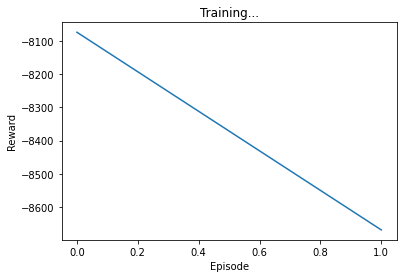

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.4021

reward -57.691172383559035
current_state2 [14.266304347826086, 12.878946268032616, 12.790253673097965, 15.755668094602372, 0, 1, 0, 1, 0, 0]
1
reward -54.413236997610404
current_state2 [14.266304347826086, 9.65920970102446, 12.54331302614444, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -50.87311325246687
current_state2 [14.266304347826086, 9.952161347252654, 12.597687866795471, 12.056959690592654, 0, 1, 0, 0, 1, 0]
1
reward -49.931261203275994
current_state2 [14.266304347826086, 9.65920970102446, 9.17204765373574, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -56.25782783250311
current_state2 [13.885295562934436, 14.822679277628945, 13.278123213426035, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -53.26166324884507
current_state2 [14.266304347826086, 12.878946268032616, 12.014912963594277, 12.101499669392089, 0, 1, 0, 0, 1, 0]
1
reward -55.47978955729872
current_state2 [14.266304347826086, 12.878946268032616, 11.586736644945212, 14.74780229649481, 0, 0, 1, 0, 1, 0]
1
reward -53.640

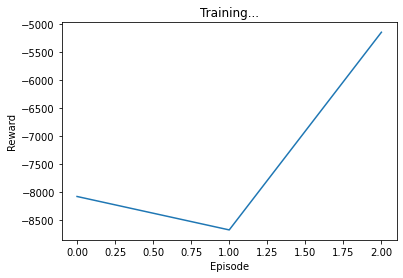

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -13.96583417316941
current_state2 [4.279891304347826, 0.0, 7.685942868821584, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -17.64625746901287
current_state2 [5.7065217391304355, 3.219736567008154, 6.719999162874282, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -28.307813820632038
current_state2 [8.559782608695654, 9.65920970102446, 8.088821510911924, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -35.79798112216695
curre

reward -53.847918014369306
current_state2 [15.692934782608695, 13.196143366413471, 12.681813861792026, 10.277026003555116, 0, 1, 0, 1, 0, 0]
5
reward -59.71457881953701
current_state2 [15.692934782608695, 12.878946268032616, 15.097734427557006, 14.044963341338695, 0, 1, 0, 1, 0, 0]
1
reward -54.81432270330916
current_state2 [14.266304347826086, 10.38953181069231, 13.340575233199164, 14.817911311591601, 0, 1, 0, 0, 1, 0]
1
reward -57.0284745921696
current_state2 [14.266304347826086, 12.167827432968018, 14.085176295960268, 14.50916651541523, 0, 1, 0, 0, 1, 0]
1
reward -59.78250761638108
current_state2 [14.266304347826086, 12.878946268032616, 14.217535684943053, 16.419721315579334, 0, 1, 0, 0, 1, 0]
1
reward -49.289501447138825
current_state2 [14.266304347826086, 9.65920970102446, 10.124526122131687, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -52.17559603677618
current_state2 [14.266304347826086, 12.878946268032616, 10.073023946402131, 12.957321474515345, 0, 0, 1, 0, 1, 0]
1
reward -5

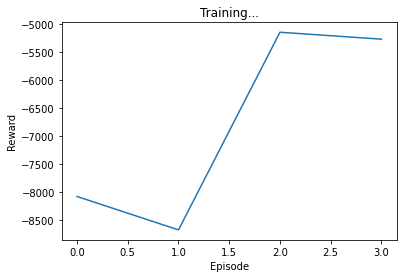

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -25.30

reward -67.46195409377651
current_state2 [12.839673913043478, 16.09868283504077, 10.48529986145212, 26.038297484240143, 0, 1, 0, 0, 1, 0]
1
reward -61.919660525949
current_state2 [12.839673913043478, 15.627304127002922, 9.472516371209128, 21.98016611469347, 0, 1, 0, 0, 1, 0]
5
reward -61.40624544411834
current_state2 [12.839673913043478, 16.001948567588663, 12.648577193776521, 17.91604576970968, 0, 1, 0, 1, 0, 0]
5
reward -68.58113755565522
current_state2 [12.839673913043478, 18.35309268166354, 13.363973663646455, 22.024397297301743, 0, 1, 0, 1, 0, 0]
5
reward -63.456636671157014
current_state2 [12.839673913043478, 15.66403675640695, 14.832036526337596, 18.120889475368994, 0, 1, 0, 1, 0, 0]
1
reward -64.77699996111998
current_state2 [12.839673913043478, 12.176518992310974, 14.177378770598004, 23.583428285167525, 0, 1, 0, 0, 1, 0]
1
reward -64.0065087369016
current_state2 [12.839673913043478, 12.878946268032616, 15.21953918885807, 21.06834936696744, 0, 0, 1, 0, 1, 0]
1
reward -59.468009

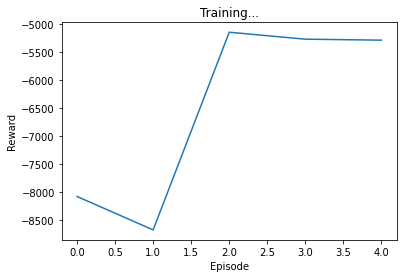

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -65.49117373890121
current_state2 [12.839673913043478, 12.878946268032616, 12.745566198190316, 25.0269873596348, 0, 1, 0, 0, 1, 0]
1
reward -62.124643523992745
current_state2 [12.839673913043478, 12.878946268032616, 12.549435697332923, 21.856587645583733, 0, 1, 0, 0, 1, 0]
1
reward -55.89141120447019
current_state2 [11.543451273763658, 12.878946268032616, 13.129085720286227, 16.339927942387693, 0, 1, 0, 0, 1, 0]
1
reward -58.432700575669514
current_state2 [12.839673913043478, 12.878946268032616, 11.065734929832434, 19.648345464760983, 0, 1, 0, 0, 1, 0]
5
reward -62.79320428231998
current_state2 [12.839673913043478, 12.878946268032616, 15.889155559529048, 19.18542854171484, 0, 1, 0, 1, 0, 0]
1
reward -56.93328666260923
current_state2 [12.839673913043478, 10.402673469566395, 17.270184519805717, 14.420754760193637, 0, 1, 0, 0, 1, 0]
1
reward -59.75275626804991
current_state2 [12.839673913043478, 12.878946268032616, 13.448643439058781, 18.585492647915036, 0, 0, 1, 0, 1, 0]
1
reward 

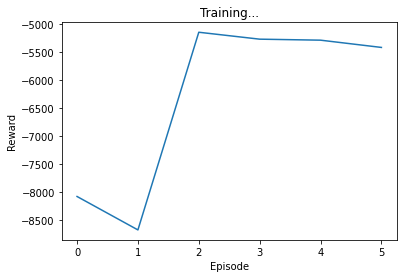

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -21.255227432433223
current_state2 [5.742048812853463, 6.439473134016308, 7.073705485563449, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.510570942619076
current_state2 [8.559782608695654, 12.878946268032616, 7.071842065890805, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -24.8

reward -67.34967380107817
current_state2 [14.266304347826086, 16.09868283504077, 22.669887642491506, 12.31479897571981, 0, 1, 0, 1, 0, 0]
1
reward -66.69703427250494
current_state2 [12.839673913043478, 15.213655890337913, 23.537780338257864, 13.105924130865686, 0, 1, 0, 0, 1, 0]
1
reward -68.66162923781334
current_state2 [12.839673913043478, 14.939447431075603, 20.551871222397953, 18.3306366712963, 0, 1, 0, 0, 1, 0]
1
reward -66.7494833114453
current_state2 [12.839673913043478, 14.143592580130942, 19.414899019884956, 18.351317798385924, 0, 1, 0, 0, 1, 0]
1
reward -66.37489202918876
current_state2 [12.839673913043478, 16.229867370720825, 19.656299493421965, 15.649051252002499, 0, 1, 0, 0, 1, 0]
1
reward -64.60162841600363
current_state2 [12.839673913043478, 16.09868283504077, 15.962375882245823, 17.700895785673563, 0, 1, 0, 0, 1, 0]
1
reward -63.65608167101149
current_state2 [12.839673913043478, 14.784235640852284, 15.581246362414678, 18.450925754701043, 0, 0, 1, 0, 1, 0]
1
reward -57.3

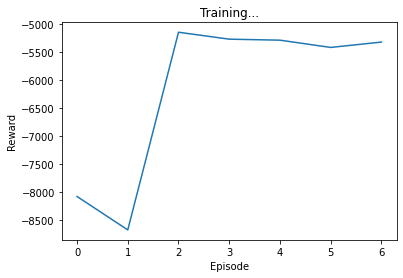

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.

reward -67.77836977109894
current_state2 [12.839673913043478, 16.09868283504077, 17.018120976206454, 19.82189204680824, 0, 1, 0, 0, 1, 0]
1
reward -61.1632917525494
current_state2 [12.839673913043478, 16.09868283504077, 14.142364702080084, 16.08257030238507, 0, 1, 0, 0, 1, 0]
5
reward -63.803178133026385
current_state2 [12.839673913043478, 15.877664337843033, 19.846378605983276, 13.239461276156595, 0, 1, 0, 1, 0, 0]
1
reward -68.74872114014066
current_state2 [11.413043478260871, 17.478399734423324, 21.06919640408315, 16.78808152337331, 0, 1, 0, 0, 1, 0]
1
reward -53.61598261108622
current_state2 [11.413043478260871, 9.65920970102446, 18.225034100182818, 12.318695331618068, 0, 1, 0, 0, 1, 0]
1
reward -59.95080967867925
current_state2 [11.413043478260871, 14.716046098489366, 15.877310179313586, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -60.6353443185363
current_state2 [12.839673913043478, 12.878946268032616, 15.189518678583438, 17.727205458876767, 0, 0, 1, 0, 1, 0]
1
reward -62.53492

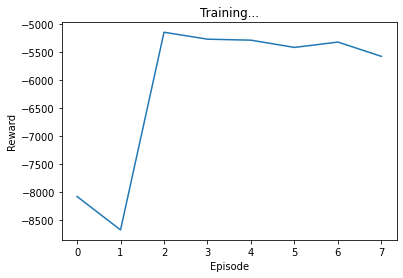

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -14.151938785135611
current_state2 [4.279891304347826, 0.0, 7.872047480787785, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -18.532420860301595
current_state2 [6.5926851304191585, 3.219736567008154, 6.719999162874282, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.89161067587369
current_state2 [8.559782608695654, 9.65920970102446, 7.672618366153576, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -33.69271819484632
curr

reward -58.63830699989131
current_state2 [15.692934782608695, 9.65920970102446, 15.484731517925555, 15.801430998332604, 0, 1, 0, 1, 0, 0]
5
reward -70.21508488146073
current_state2 [17.1195652173913, 15.574955702498142, 15.760494970571322, 19.760068990999958, 0, 1, 0, 1, 0, 0]
1
reward -62.64658629923685
current_state2 [17.1195652173913, 13.676556876022387, 15.016764705133458, 14.83369950068971, 0, 1, 0, 0, 1, 0]
5
reward -66.24058508321473
current_state2 [15.692934782608695, 14.088676279137125, 19.625274520779193, 14.83369950068971, 0, 1, 0, 1, 0, 0]
1
reward -68.86155011867683
current_state2 [15.692934782608695, 16.09868283504077, 19.955946252057988, 15.113986248969388, 0, 1, 0, 0, 1, 0]
5
reward -59.745941980021655
current_state2 [15.692934782608695, 9.65920970102446, 16.906624525952118, 15.487172970436385, 0, 1, 0, 1, 0, 0]
1
reward -61.25104311789245
current_state2 [15.692934782608695, 9.65920970102446, 19.548726936176987, 14.350171698082306, 0, 0, 1, 0, 1, 0]
1
reward -62.4216403

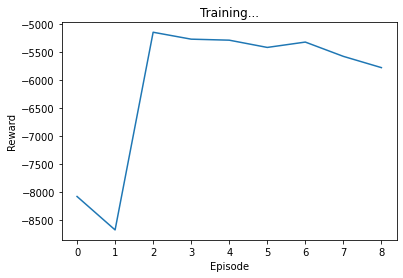

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -70.7397384549199
current_state2 [15.692934782608695, 19.31841940204892, 18.2451788607068, 15.483205409555476, 0, 1, 0, 0, 1, 0]
1
reward -64.60811006742338
current_state2 [15.20398022699467, 16.09868283504077, 15.361037082772516, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -58.31074724070987
current_state2 [14.266304347826086, 12.878946268032616, 13.07810777795294, 16.087388846898236, 0, 1, 0, 0, 1, 0]
1
reward -55.075135252010824
current_state2 [14.266304347826086, 9.65920970102446, 14.55205900914135, 14.597562194018929, 0, 1, 0, 0, 1, 0]
1
reward -52.38683088314621
current_state2 [14.266304347826086, 9.65920970102446, 13.078876633856257, 13.38244020043941, 0, 1, 0, 0, 1, 0]
5
reward -59.877394489391385
current_state2 [14.266304347826086, 16.09868283504077, 13.055353947374492, 14.457053359150036, 0, 1, 0, 1, 0, 0]
5
reward -61.249048478923285
current_state2 [15.692934782608695, 15.546754101336962, 11.886874523598177, 16.122485071379447, 0, 0, 1, 1, 0, 0]
1
reward -68.6541266

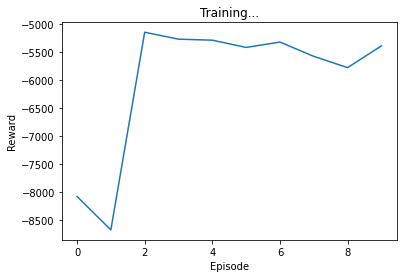

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.549374871198907
current_state2 [5.7065217391304355, 6.439473134016308, 6.403379998052165, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.538184955853634
current_state2 [8.559782608695654, 9.65920970102446, 7.319192646133518, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.602

reward -54.88152458216493
current_state2 [12.839673913043478, 12.878946268032616, 13.92344312493224, 13.239461276156595, 0, 1, 0, 0, 1, 0]
3
reward -52.601729125719125
current_state2 [11.413043478260871, 8.6825832667297, 15.585466401927464, 14.920635978801089, 0, 1, 0, 0, 0, 1]
3
reward -57.966406196451366
current_state2 [12.839673913043478, 11.691537772119853, 16.09671045108091, 15.338484060207128, 0, 1, 0, 0, 0, 1]
3
reward -62.32553236749588
current_state2 [12.839673913043478, 9.65920970102446, 20.375045328660214, 17.45160342476773, 0, 1, 0, 0, 0, 1]
5
reward -58.47073792283308
current_state2 [12.839673913043478, 6.439473134016308, 21.64716027043005, 15.544430605343246, 0, 1, 0, 1, 0, 0]
1
reward -55.49795067868615
current_state2 [12.839673913043478, 2.475854448769068, 20.374428827733727, 17.807993489139875, 0, 1, 0, 0, 1, 0]
1
reward -56.80346489308003
current_state2 [12.839673913043478, 0.0, 22.349736855634493, 19.614054124402063, 0, 0, 1, 0, 1, 0]
5
reward -60.46730333285545
curr

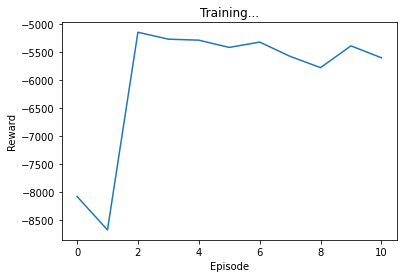

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -13.96583417316941
current_state2 [4.279891304347826, 0.0, 7.685942868821584, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -17.731672637891304
current_state2 [5.7065217391304355, 3.219736567008154, 6.805414331752714, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -28.10260415345134
current_state2 [8.559782608695654, 9.65920970102446, 7.883611843731226, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -34.27203915848518
curre

reward -66.57882253727203
current_state2 [14.266304347826086, 13.604562595635826, 16.60755544350916, 20.100400150300963, 0, 1, 0, 0, 1, 0]
1
reward -61.019747618445244
current_state2 [14.266304347826086, 13.649545522596156, 13.90556291696636, 17.19833483105664, 0, 1, 0, 0, 1, 0]
5
reward -60.33405815652662
current_state2 [14.266304347826086, 16.15775398468127, 13.192599550800056, 14.717400273219212, 0, 1, 0, 1, 0, 0]
5
reward -69.8508913687359
current_state2 [14.266304347826086, 16.09868283504077, 19.273686068750628, 18.21221811711842, 0, 1, 0, 1, 0, 0]
1
reward -62.34138747954013
current_state2 [14.266304347826086, 16.09868283504077, 17.70467051815958, 12.271729778513697, 0, 1, 0, 0, 1, 0]
5
reward -62.41440792229604
current_state2 [14.266304347826086, 16.09868283504077, 15.21572123873948, 14.83369950068971, 0, 1, 0, 1, 0, 0]
1
reward -66.82401352243834
current_state2 [14.266304347826086, 12.878946268032616, 17.836960548925973, 19.84180235765366, 0, 0, 1, 0, 1, 0]
1
reward -64.9699800

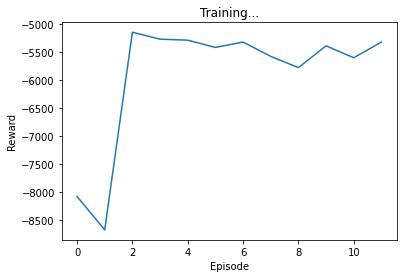

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -62.27278410006622
current_state2 [15.692934782608695, 12.878946268032616, 13.051544480350655, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -59.883351309524336
current_state2 [17.1195652173913, 12.878946268032616, 12.011152393612122, 15.873687430488296, 0, 1, 0, 0, 1, 0]
1
reward -54.09779469577232
current_state2 [17.1195652173913, 9.65920970102446, 13.898326160371964, 11.420693616984595, 0, 1, 0, 0, 1, 0]
1
reward -59.45975286459187
current_state2 [17.1195652173913, 9.65920970102446, 14.824960805864379, 15.856017140311728, 0, 1, 0, 0, 1, 0]
1
reward -59.676472086590515
current_state2 [17.1195652173913, 12.878946268032616, 11.733550678551174, 15.94440992261542, 0, 1, 0, 0, 1, 0]
5
reward -63.988885654471794
current_state2 [18.54619565217391, 14.110161040560188, 12.182534336315959, 17.149994625421733, 0, 1, 0, 1, 0, 0]
5
reward -65.17400279062197
current_state2 [18.54619565217391, 9.65920970102446, 15.336576858926234, 19.63202057849736, 0, 0, 1, 1, 0, 0]
1
reward -64.20608116025

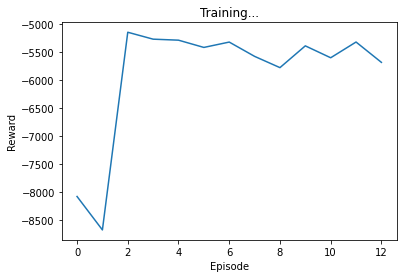

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -25.30

reward -64.0270344777771
current_state2 [14.266304347826086, 16.09868283504077, 11.460970124248071, 20.20107717066217, 0, 1, 0, 0, 1, 0]
1
reward -55.72461943564907
current_state2 [14.266304347826086, 9.65920970102446, 10.062269696988137, 19.736835689810384, 0, 1, 0, 0, 1, 0]
1
reward -59.97840433379214
current_state2 [14.266304347826086, 9.65920970102446, 11.730851571765628, 22.32203871317597, 0, 1, 0, 0, 1, 0]
5
reward -62.34795062458899
current_state2 [14.266304347826086, 12.878946268032616, 13.72657601541616, 19.476123993314133, 0, 1, 0, 1, 0, 0]
1
reward -63.43615070277734
current_state2 [15.692934782608695, 16.09868283504077, 12.248863862262164, 17.395669222865717, 0, 1, 0, 0, 1, 0]
1
reward -55.61965429548513
current_state2 [15.692934782608695, 12.191233675859166, 10.901786336327557, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -56.53333449205944
current_state2 [15.692934782608695, 8.816282985564479, 13.667334587673787, 16.356782136212484, 0, 0, 1, 0, 1, 0]
1
reward -52.7582756

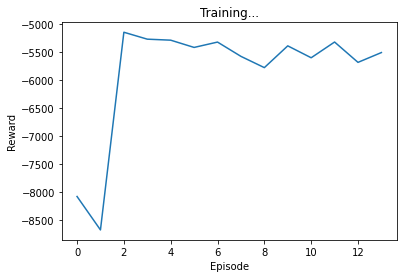

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.55

reward -65.57545885713675
current_state2 [12.839673913043478, 16.09868283504077, 12.350329976251736, 22.286772132800767, 0, 1, 0, 0, 1, 0]
1
reward -57.94896365120229
current_state2 [14.266304347826086, 9.838025246382768, 12.227543990276287, 19.617090066717143, 0, 1, 0, 0, 1, 0]
1
reward -50.61589804308126
current_state2 [14.266304347826086, 3.219736567008154, 13.838518627833926, 17.29133850041309, 0, 1, 0, 0, 1, 0]
1
reward -49.655259562777346
current_state2 [14.266304347826086, 3.219736567008154, 12.705629533049136, 17.46358911489397, 0, 1, 0, 0, 1, 0]
5
reward -59.261064765771906
current_state2 [17.1195652173913, 9.65920970102446, 12.205764402800565, 18.276525444555574, 0, 1, 0, 1, 0, 0]
1
reward -59.48564540593311
current_state2 [18.54619565217391, 16.09868283504077, 10.68308195933376, 12.157684959384667, 0, 1, 0, 0, 1, 0]
1
reward -68.62138622182387
current_state2 [19.407159807185657, 16.963503196437838, 14.30631329558496, 15.94440992261542, 0, 0, 1, 0, 1, 0]
1
reward -61.32325769

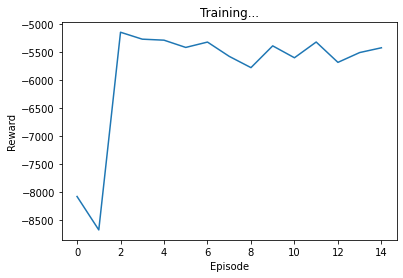

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.0918299842341
current_state2 [2.8532608695652177, 0.0, 7.238569114668882, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -14.704517485738425
current_state2 [4.279891304347826, 0.0, 8.424626181390598, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -18.6880455887502
current_state2 [5.7065217391304355, 3.219736567008154, 7.761787282611609, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -25.5610474617685
current_state2 [8.559782608695654, 6.439473134016308, 8.561791719056536, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -31.134068431111157
current

reward -63.90682557643609
current_state2 [12.839673913043478, 12.878946268032616, 14.110798977263173, 22.077406418096825, 0, 1, 0, 1, 0, 0]
5
reward -52.42284912031644
current_state2 [12.839673913043478, 6.439473134016308, 11.019541691799793, 20.124160381456857, 0, 1, 0, 1, 0, 0]
1
reward -55.89757199992425
current_state2 [12.839673913043478, 6.439473134016308, 14.762082657766141, 19.85634229509832, 0, 1, 0, 0, 1, 0]
1
reward -59.677940617912554
current_state2 [11.413043478260871, 9.65920970102446, 14.866501966340715, 21.739185472286504, 0, 1, 0, 0, 1, 0]
5
reward -60.548448493280134
current_state2 [12.839673913043478, 11.0922058721314, 14.923166207840621, 19.693402500264636, 0, 1, 0, 1, 0, 0]
1
reward -63.29202922455782
current_state2 [12.839673913043478, 12.878946268032616, 15.546427597500902, 20.026981445980827, 0, 1, 0, 0, 1, 0]
1
reward -62.086236734659266
current_state2 [12.839673913043478, 12.878946268032616, 15.836541895374108, 18.531074658209068, 0, 0, 1, 0, 1, 0]
1
reward -56

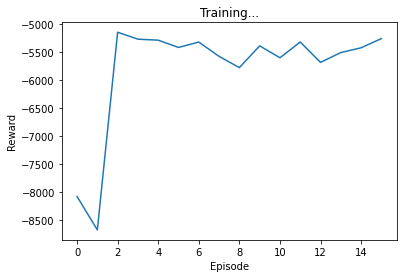

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -26.399147544496568
current_state2 [7.133152173913045, 9.65920970102446, 7.606785669559063, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -24.0159

reward -60.030153432059464
current_state2 [7.133152173913045, 13.580288865437645, 15.47676389594891, 21.839948496759863, 0, 1, 0, 0, 1, 0]
3
reward -57.90060253403975
current_state2 [7.133152173913045, 9.65920970102446, 18.093387123501138, 21.01485353560111, 0, 1, 0, 0, 0, 1]
3
reward -51.99918519172441
current_state2 [7.133152173913045, 3.219736567008154, 19.90519974140203, 19.741096709401184, 0, 1, 0, 0, 0, 1]
3
reward -59.62526261422103
current_state2 [7.133152173913045, 3.219736567008154, 26.06104558204958, 21.211328291250258, 0, 1, 0, 0, 0, 1]
1
reward -57.59466313079018
current_state2 [8.191007929003122, 3.219736567008154, 26.32125922291544, 17.862659411863458, 0, 1, 0, 0, 1, 0]
1
reward -56.01009776271796
current_state2 [9.986413043478262, 3.219736567008154, 24.24501921706262, 16.558928935168932, 0, 1, 0, 0, 1, 0]
1
reward -52.460824993464975
current_state2 [9.986413043478262, 0.0, 21.73393473350266, 18.740477216484052, 0, 0, 1, 0, 1, 0]
3
reward -60.63851232657342
current_state

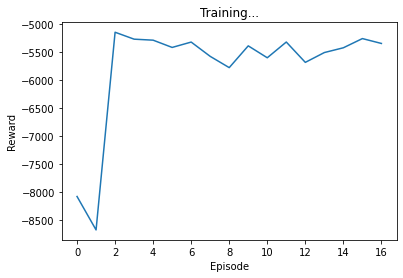

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -31.750186366384526
current_state2 [8.559782608695654, 12.878946268032616, 8.311457489656256, 0.0, 0, 1, 0, 0, 0, 1]
1
reward -29.5

reward -77.2606350061789
current_state2 [21.399456521739133, 13.77345350313847, 12.334840924542938, 27.752884056758358, 0, 1, 0, 0, 1, 0]
1
reward -72.99252219490548
current_state2 [21.399456521739133, 13.184778327406505, 11.20123865421488, 25.207048691544955, 0, 1, 0, 0, 1, 0]
1
reward -73.11538773999713
current_state2 [21.399456521739133, 12.878946268032616, 11.618313630435248, 25.218671319790136, 0, 1, 0, 0, 1, 0]
1
reward -71.02792741044006
current_state2 [21.399456521739133, 12.878946268032616, 13.508700149487106, 21.240824471181202, 0, 1, 0, 0, 1, 0]
5
reward -74.58969879073797
current_state2 [21.13215165240856, 16.09868283504077, 13.817170350132521, 21.541693953156127, 0, 1, 0, 1, 0, 0]
1
reward -70.73904473837499
current_state2 [19.972826086956523, 12.878946268032616, 14.068136609742785, 21.81913577364307, 0, 1, 0, 0, 1, 0]
1
reward -68.4421092034469
current_state2 [19.972826086956523, 6.439473134016308, 13.648075443011528, 26.381734539462542, 0, 0, 1, 0, 1, 0]
1
reward -63.856

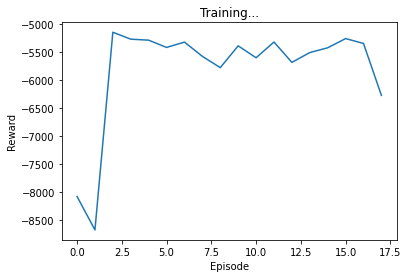

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -20.358009265804988
current_state2 [4.279891304347826, 5.356676079486579, 8.72144188197058, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -23.937342714532182
current_state2 [5.736513921880895, 6.439473134016308, 9.76135565863498, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -30.781894973494772
current_state2 [8.559782608695654, 9.65920970102446, 10.562902663774658, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -24.51753

reward -63.12214476071415
current_state2 [15.692934782608695, 11.419439898897151, 8.378213007931738, 25.631557071276557, 0, 1, 0, 0, 1, 0]
1
reward -70.0575780367724
current_state2 [15.692934782608695, 12.68190959933489, 13.521151007339272, 26.16158264748954, 0, 1, 0, 0, 1, 0]
1
reward -58.18696603645097
current_state2 [15.692934782608695, 9.65920970102446, 9.624126853621956, 21.210694699195855, 0, 1, 0, 0, 1, 0]
1
reward -64.67210801743256
current_state2 [15.692934782608695, 9.65920970102446, 12.663863473145387, 24.65610006065403, 0, 1, 0, 0, 1, 0]
1
reward -64.923345446714
current_state2 [15.692934782608695, 9.65920970102446, 12.453649461811393, 25.11755150126945, 0, 1, 0, 0, 1, 0]
1
reward -68.7521397165485
current_state2 [17.1195652173913, 15.659856525734895, 10.199419959996039, 23.773298013426267, 0, 1, 0, 0, 1, 0]
1
reward -59.43755198072938
current_state2 [17.1195652173913, 10.022549255117495, 7.825156564079908, 22.470280944140683, 0, 0, 1, 0, 1, 0]
1
reward -63.985617634541455


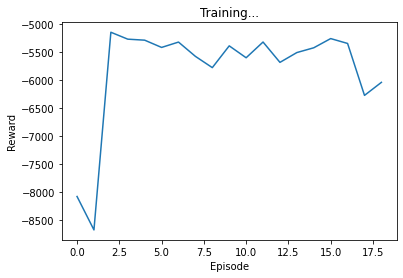

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

current_state2 [34.23913043478262, 3.219736567008154, 26.886955097034406, 13.125262671533212, 0, 1, 0, 0, 1, 0]
1
reward -85.72431232306442
current_state2 [37.09239130434784, 6.439473134016308, 24.196642034069953, 15.995805850630324, 0, 1, 0, 0, 1, 0]
1
reward -73.25228164012093
current_state2 [37.09239130434784, 6.439473134016308, 18.153636069701903, 9.566781132054869, 0, 1, 0, 0, 1, 0]
5
reward -85.76841861829782
current_state2 [38.51902173913045, 12.878946268032616, 19.35158372717627, 13.018866883958482, 0, 1, 0, 1, 0, 0]
1
reward -96.42080181493947
current_state2 [38.51902173913045, 16.09868283504077, 24.969397740078534, 14.83369950068971, 0, 1, 0, 0, 1, 0]
5
reward -95.45252144343986
current_state2 [38.51902173913045, 16.09868283504077, 26.563087090754937, 12.271729778513697, 0, 1, 0, 1, 0, 0]
5
reward -98.3499169539912
current_state2 [38.51902173913045, 12.878946268032616, 29.0629929143031, 15.88895603252503, 0, 0, 1, 1, 0, 0]
5
reward -93.55102333230097
current_state2 [38.519021

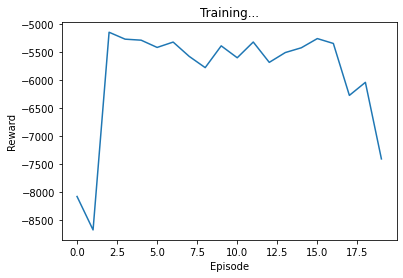

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -66.17391995791662
current_state2 [14.266304347826086, 12.878946268032616, 18.379310772983676, 18.64935856907425, 0, 1, 0, 0, 0, 1]
3
reward -62.87071008011226
current_state2 [14.266304347826086, 9.65920970102446, 21.431903644004894, 15.513292387256827, 0, 1, 0, 0, 0, 1]
3
reward -51.02135778800429
current_state2 [13.347925536748514, 3.219736567008154, 22.863797626898414, 9.589898057349208, 0, 1, 0, 0, 0, 1]
1
reward -50.3187146539546
current_state2 [12.839673913043478, 0.0, 22.2060693119429, 13.272971428968221, 0, 1, 0, 0, 1, 0]
3
reward -58.90893240162812
current_state2 [14.266304347826086, 0.0, 26.463044708846848, 16.179583344955187, 0, 1, 0, 0, 0, 1]
3
reward -60.24096487283395
current_state2 [17.1195652173913, 0.0, 27.881938379286055, 13.239461276156595, 0, 1, 0, 0, 0, 1]
3
reward -65.97968890732417
current_state2 [18.54619565217391, 0.0, 29.518203674059535, 15.915289581090724, 0, 0, 1, 0, 0, 1]
3
reward -71.3962728641248
current_state2 [21.31752210588616, 0.0, 31.705623137

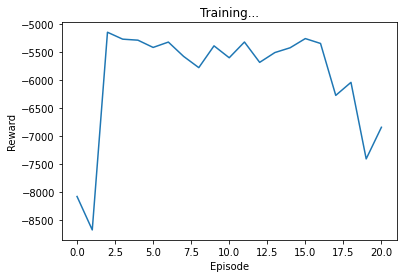

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -20.086547496934692
current_state2 [4.279891304347826, 5.356676079486579, 8.449980113100285, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -22.36779704782719
current_state2 [5.95513138901473, 6.439473134016308, 7.973192524796152, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.941349154080953
current_state2 [8.559782608695654, 6.439473134016308, 7.942093411368989, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -21.61022

reward -54.546915938715514
current_state2 [15.692934782608695, 6.439473134016308, 11.765149453016257, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -51.94802446023316
current_state2 [15.692934782608695, 4.030373164236497, 14.280306590772545, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -51.452477869374405
current_state2 [15.692934782608695, 6.439473134016308, 14.780467671859316, 12.539602280890087, 0, 1, 0, 0, 1, 0]
1
reward -56.482744563540344
current_state2 [18.54619565217391, 11.217579905113762, 10.899350524393174, 13.819618481859498, 0, 1, 0, 0, 1, 0]
1
reward -59.2185782279034
current_state2 [19.6581674189498, 12.878946268032616, 12.40973476240729, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -55.05383548528691
current_state2 [18.54619565217391, 12.878946268032616, 8.957686440473655, 12.67100712460673, 0, 1, 0, 0, 1, 0]
1
reward -63.773177057470015
current_state2 [18.54619565217391, 16.09868283504077, 11.183888647639911, 15.94440992261542, 0, 0, 1, 0, 1, 0]
1
reward -60.9643492

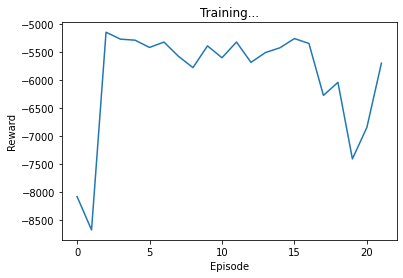

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -48.1254174144955
current_state2 [15.692934782608695, 6.439473134016308, 12.059526104353116, 11.933483393517387, 0, 1, 0, 0, 1, 0]
1
reward -54.560129314538045
current_state2 [15.692934782608695, 12.641551822664804, 9.73249208689943, 14.493150622365121, 0, 1, 0, 0, 1, 0]
1
reward -58.02162067448609
current_state2 [17.1195652173913, 13.378206897431433, 12.14140835922394, 13.38244020043941, 0, 1, 0, 0, 1, 0]
1
reward -61.42382237727856
current_state2 [15.692934782608695, 16.09868283504077, 12.99607521298116, 14.636129546647938, 0, 1, 0, 0, 1, 0]
1
reward -57.22135437446564
current_state2 [15.692934782608695, 13.783270597728919, 9.727495713695658, 16.01765328043237, 0, 1, 0, 0, 1, 0]
1
reward -59.917757608647534
current_state2 [15.692934782608695, 12.878946268032616, 11.294976671924655, 18.050899886081563, 0, 1, 0, 0, 1, 0]
1
reward -59.81672411818562
current_state2 [15.692934782608695, 12.878946268032616, 10.75199866059885, 18.492844406945462, 0, 0, 1, 0, 1, 0]
1
reward -60.489065

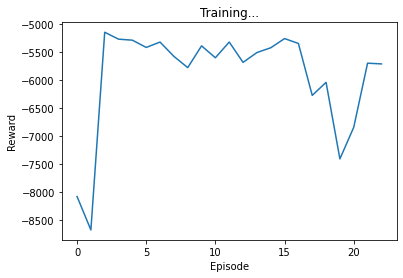

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.70651729516435
current_state2 [5.8946060775001845, 6.439473134016308, 7.3724380836478565, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -31.1203255242111
current_state2 [8.559782608695654, 12.878946268032616, 7.68159664748283, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -25.38254

reward -69.56562836512506
current_state2 [21.399456521739133, 16.09868283504077, 10.63540514137531, 19.43208386696985, 0, 1, 0, 0, 1, 0]
1
reward -66.47661663865343
current_state2 [21.399456521739133, 16.625146985789343, 11.618313630435246, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -60.766850810791304
current_state2 [21.399456521739133, 16.09868283504077, 8.029250177854806, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -73.17260295620427
current_state2 [21.399456521739133, 18.71874741001723, 12.405040455373657, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -65.91086549289025
current_state2 [21.399456521739133, 13.719172241282296, 12.847826807253412, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -65.83140799233452
current_state2 [21.399456521739133, 12.878946268032616, 10.501392735025192, 19.05161246753758, 0, 1, 0, 0, 1, 0]
1
reward -66.31337602706736
current_state2 [21.399456521739133, 12.197375378101928, 11.092816957120853, 19.623727170105454, 0, 0, 1, 0, 1, 0]
3
reward -66.8563

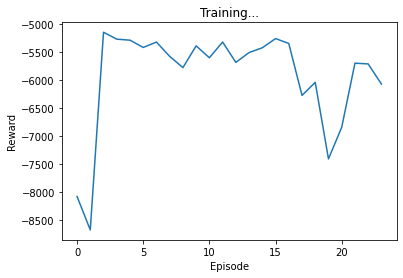

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -20.086547496934692
current_state2 [4.279891304347826, 5.356676079486579, 8.449980113100285, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -22.36779704782719
current_state2 [5.95513138901473, 6.439473134016308, 7.973192524796152, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.941349154080953
current_state2 [8.559782608695654, 6.439473134016308, 7.942093411368989, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -22.25835

reward -67.85978051549112
current_state2 [21.399456521739133, 9.65920970102446, 13.589786001477272, 21.211328291250258, 0, 1, 0, 1, 0, 0]
5
reward -76.57052939718106
current_state2 [22.826086956521742, 12.878946268032616, 16.4024216840211, 22.46307448860561, 0, 1, 0, 1, 0, 0]
5
reward -74.6690825339903
current_state2 [22.826086956521742, 9.65920970102446, 16.271495886941555, 23.91228998950255, 0, 1, 0, 1, 0, 0]
5
reward -72.37346901215767
current_state2 [22.826086956521742, 9.65920970102446, 15.172628265421356, 22.715544089190114, 0, 1, 0, 1, 0, 0]
5
reward -74.56356884318001
current_state2 [21.788422429595244, 16.09868283504077, 15.120746901990756, 19.555716676553242, 0, 1, 0, 1, 0, 0]
1
reward -82.90289116579429
current_state2 [22.826086956521742, 16.09868283504077, 18.52894396311207, 23.44917741111971, 0, 1, 0, 0, 1, 0]
5
reward -80.18069265070595
current_state2 [22.826086956521742, 14.891006680473609, 18.576595573698924, 21.88700344001167, 0, 0, 1, 1, 0, 0]
1
reward -78.40830784895

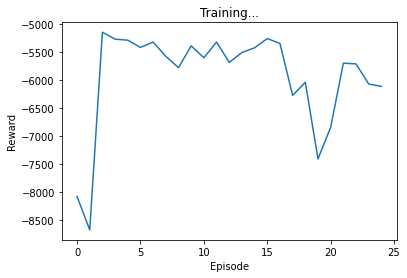

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -12.246461301441915
current_state2 [2.8532608695652177, 0.0, 7.393200431876696, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -14.151938785135611
current_state2 [4.279891304347826, 0.0, 7.872047480787785, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -17.68257092664422
current_state2 [5.742835196761785, 3.219736567008154, 6.719999162874282, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -28.028326937089922
current_state2 [8.559782608695654, 9.65920970102446, 7.809334627369808, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -32.69606889631088
curre

reward -69.88237952206701
current_state2 [21.399456521739133, 13.669667816316815, 18.965785331776694, 13.847469852234374, 0, 1, 0, 0, 1, 0]
1
reward -69.90883708036796
current_state2 [21.399456521739133, 12.878946268032616, 17.86062793057107, 15.769806360025148, 0, 1, 0, 0, 1, 0]
1
reward -61.660185606642365
current_state2 [21.399456521739133, 12.878946268032616, 12.142321540714025, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -69.60120354294367
current_state2 [21.399456521739133, 16.09868283504077, 16.570389368355563, 13.5326748178082, 0, 1, 0, 0, 1, 0]
1
reward -66.39421039278382
current_state2 [21.399456521739133, 16.09868283504077, 14.624341257490219, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -59.67759942139644
current_state2 [19.972826086956523, 16.09868283504077, 10.588050067093972, 11.018040432305169, 0, 1, 0, 0, 1, 0]
1
reward -66.23014043925929
current_state2 [19.972826086956523, 16.09868283504077, 13.641138454197172, 14.51749306306482, 0, 0, 1, 0, 1, 0]
1
reward -67.37

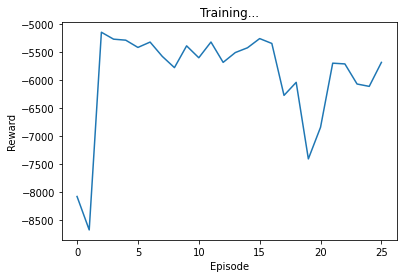

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -25.25

reward -69.43062294346163
current_state2 [25.67934782608696, 6.439473134016308, 19.61973376991744, 15.692068213440924, 0, 1, 0, 0, 1, 0]
1
reward -79.11317135004896
current_state2 [28.532608695652183, 12.878946268032616, 19.757206463748737, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -75.89960142033163
current_state2 [28.532608695652183, 16.09868283504077, 18.250269457333516, 11.018040432305169, 0, 1, 0, 0, 1, 0]
3
reward -76.79694053001596
current_state2 [28.532608695652183, 16.09868283504077, 16.687259013931502, 13.478389985391509, 0, 1, 0, 0, 0, 1]
3
reward -79.9676146666167
current_state2 [28.303753287847595, 16.09868283504077, 20.577238790015688, 12.987939753712654, 0, 1, 0, 0, 0, 1]
5
reward -81.2223070937376
current_state2 [27.105978260869573, 16.09868283504077, 23.048020450819166, 12.969625547008093, 0, 1, 0, 1, 0, 0]
5
reward -81.43163510710907
current_state2 [27.105978260869573, 18.740426086570338, 20.202790559229747, 13.38244020043941, 0, 0, 1, 1, 0, 0]
5
reward -74.208375

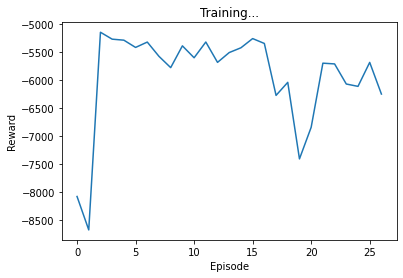

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

current_state2 [24.25271739130435, 5.276102204415436, 11.904826691280505, 24.50500305134047, 0, 1, 0, 0, 1, 0]
5
reward -78.41575505359708
current_state2 [25.67934782608696, 6.955416708893907, 18.44247580328775, 25.33851471532847, 0, 1, 0, 1, 0, 0]
1
reward -76.70232228487285
current_state2 [27.105978260869573, 12.878946268032616, 15.893817397927396, 18.82358035804326, 0, 1, 0, 0, 1, 0]
5
reward -77.54766398323939
current_state2 [27.105978260869573, 11.336646970724306, 17.56259112685139, 19.542447624794125, 0, 1, 0, 1, 0, 0]
1
reward -77.09091288329424
current_state2 [27.105978260869573, 9.65920970102446, 20.963373172005763, 17.362351749394435, 0, 1, 0, 0, 1, 0]
1
reward -72.39864078752804
current_state2 [27.105978260869573, 9.65920970102446, 18.799753324944295, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -72.89741152230121
current_state2 [28.532608695652183, 9.65920970102446, 15.893865976693132, 16.811727148931435, 0, 0, 1, 0, 1, 0]
1
reward -65.97347956246068
current_state2 [27.407

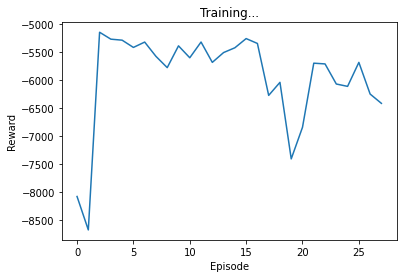

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -63.09309492362879
current_state2 [22.826086956521742, 12.878946268032616, 13.055099302407193, 12.332962396667243, 0, 1, 0, 0, 1, 0]
5
reward -58.6203768662198
current_state2 [22.826086956521742, 9.65920970102446, 11.863350430159903, 12.271729778513697, 0, 1, 0, 1, 0, 0]
1
reward -59.520837484057175
current_state2 [22.826086956521742, 6.439473134016308, 15.983547615005435, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -58.00755175814158
current_state2 [22.826086956521742, 6.439473134016308, 14.470261889089837, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -53.7826187122263
current_state2 [24.25271739130435, 6.439473134016308, 11.571125262941784, 9.519302923963858, 0, 1, 0, 0, 1, 0]
1
reward -56.20348511358316
current_state2 [25.06246607091776, 9.952816372748527, 8.43562329895565, 10.75257937096123, 0, 1, 0, 0, 1, 0]
5
reward -67.83393816377092
current_state2 [25.67934782608696, 12.878946268032616, 13.893203869211943, 13.38244020043941, 0, 0, 1, 1, 0, 0]
1
reward -69.3117012214

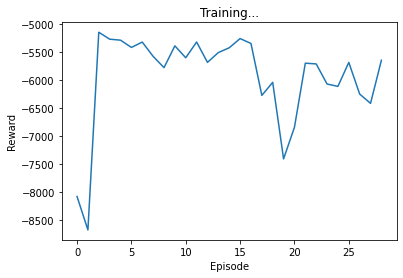

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -29.23

reward -57.17437601289234
current_state2 [12.839673913043478, 12.878946268032616, 12.220077957609792, 17.235677874206456, 0, 1, 0, 0, 1, 0]
1
reward -58.99094089506318
current_state2 [12.839673913043478, 16.09868283504077, 12.629135184159185, 15.423448962819757, 0, 1, 0, 0, 1, 0]
1
reward -48.412032230112125
current_state2 [12.839673913043478, 13.79603449956587, 8.758283385197606, 11.018040432305169, 0, 1, 0, 0, 1, 0]
1
reward -54.2217694173104
current_state2 [12.839673913043478, 12.878946268032616, 14.231419457720607, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -56.40072183565213
current_state2 [12.839673913043478, 15.13613532236382, 14.15318282173114, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -48.84707269693302
current_state2 [12.839673913043478, 12.018154279838376, 9.71751472553747, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -48.758043800486284
current_state2 [12.839673913043478, 11.027555448820706, 8.691645616262647, 14.199168822359452, 0, 0, 1, 0, 1, 0]
5
reward -54.08

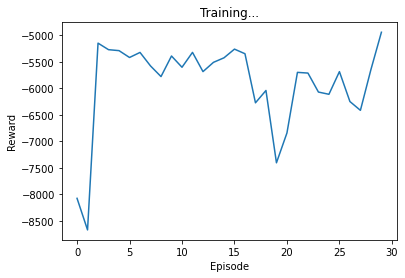

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.3959

reward -83.75451224127703
current_state2 [24.25271739130435, 16.09868283504077, 19.20604508783258, 22.19706692709933, 0, 1, 0, 0, 1, 0]
1
reward -78.38043869725065
current_state2 [24.25271739130435, 12.878946268032616, 17.47440335897326, 21.77437167894043, 0, 1, 0, 0, 1, 0]
5
reward -72.51247100848848
current_state2 [24.25271739130435, 12.878946268032616, 15.98513812628579, 17.395669222865717, 0, 1, 0, 1, 0, 0]
1
reward -77.96559500723644
current_state2 [24.25271739130435, 12.878946268032616, 21.438262125033766, 17.395669222865717, 0, 1, 0, 0, 1, 0]
1
reward -75.198250644925
current_state2 [24.25271739130435, 13.466963811974106, 18.172899834081893, 17.305669607564656, 0, 1, 0, 0, 1, 0]
1
reward -69.35339858352515
current_state2 [24.25271739130435, 12.878946268032616, 15.388035423498474, 14.83369950068971, 0, 1, 0, 0, 1, 0]
3
reward -70.68673204287418
current_state2 [24.25271739130435, 10.468580321499951, 15.45905468527845, 18.50637964479143, 0, 0, 1, 0, 0, 1]
1
reward -74.2001986280709

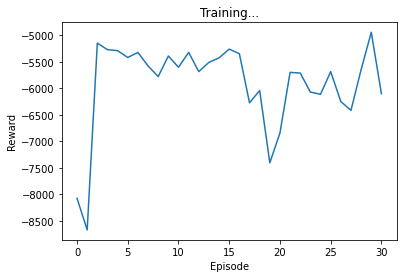

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.549374871198907
current_state2 [5.7065217391304355, 6.439473134016308, 6.403379998052165, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.538184955853634
current_state2 [8.559782608695654, 9.65920970102446, 7.319192646133518, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.602

reward -62.605558410020876
current_state2 [12.839673913043478, 13.980872849814977, 12.573683355912168, 21.211328291250258, 0, 1, 0, 0, 1, 0]
1
reward -60.51354538156643
current_state2 [12.839673913043478, 12.878946268032616, 11.481319095331758, 21.31360610515858, 0, 1, 0, 0, 1, 0]
1
reward -56.35294625846976
current_state2 [12.839673913043478, 9.65920970102446, 10.19941995999604, 21.654642684405776, 0, 1, 0, 0, 1, 0]
1
reward -60.89314198748128
current_state2 [12.839673913043478, 11.513998489543258, 15.552445335068697, 18.987024249825843, 0, 1, 0, 0, 1, 0]
5
reward -62.984340343816996
current_state2 [12.839673913043478, 12.878946268032616, 16.021970280469976, 19.243749882270922, 0, 1, 0, 1, 0, 0]
1
reward -58.771928860901866
current_state2 [14.266304347826086, 9.65920970102446, 14.800952626918297, 18.045462185133022, 0, 1, 0, 0, 1, 0]
1
reward -51.82594837169427
current_state2 [14.266304347826086, 3.219736567008154, 14.944238233994305, 17.395669222865717, 0, 0, 1, 0, 1, 0]
1
reward -49

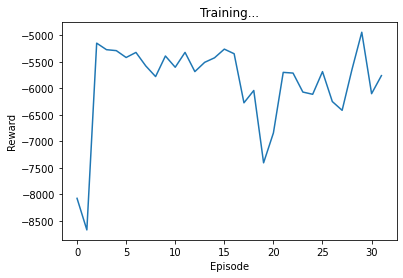

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -31.844716945263727
current_state2 [8.559782608695654, 12.878946268032616, 8.405988068535457, 0.0, 0, 1, 0, 0, 0, 1]
3
reward -29.0

reward -80.07411101750945
current_state2 [25.67934782608696, 6.439473134016308, 20.815100842576864, 25.140189214829316, 0, 1, 0, 0, 1, 0]
1
reward -85.86658436087194
current_state2 [28.532608695652183, 6.439473134016308, 22.671527026088334, 26.222975505115112, 0, 1, 0, 0, 1, 0]
1
reward -76.89107566059623
current_state2 [28.532608695652183, 3.219736567008154, 20.88559625537775, 22.253134142558135, 0, 1, 0, 0, 1, 0]
1
reward -75.30032759583466
current_state2 [27.105978260869573, 3.219736567008154, 18.3001644549483, 24.67444831300863, 0, 1, 0, 0, 1, 0]
1
reward -77.8516678598359
current_state2 [28.981264031648784, 9.65920970102446, 14.889517897007364, 22.321676230155287, 0, 1, 0, 0, 1, 0]
3
reward -84.01166686779918
current_state2 [29.959239130434796, 16.09868283504077, 14.742416611073358, 21.211328291250258, 0, 1, 0, 0, 0, 1]
1
reward -91.134105659353
current_state2 [31.3858695652174, 16.09868283504077, 18.96186647297603, 22.6876867861188, 0, 0, 1, 0, 1, 0]
1
reward -94.75796984408643
c

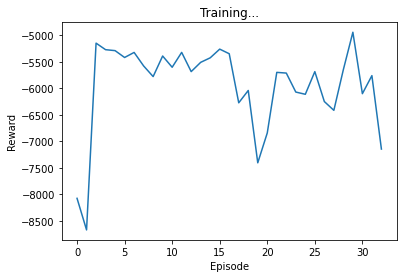

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -53.0394050579254
current_state2 [11.413043478260871, 11.698166841646751, 8.712018748330864, 19.216175989686917, 0, 1, 0, 0, 1, 0]
5
reward -60.526602910491754
current_state2 [10.834886142040471, 10.729554360551036, 15.889155559529046, 21.0730068483712, 0, 1, 0, 1, 0, 0]
5
reward -59.14102416904287
current_state2 [9.986413043478262, 12.878946268032616, 14.545155726954192, 19.7305091305778, 0, 1, 0, 1, 0, 0]
1
reward -51.45791554996115
current_state2 [11.413043478260871, 9.65920970102446, 12.441252448060396, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -55.741568854896165
current_state2 [11.413043478260871, 9.65920970102446, 16.713141224050645, 15.956174451560186, 0, 1, 0, 0, 1, 0]
1
reward -61.07594061660349
current_state2 [11.413043478260871, 12.878946268032616, 15.023881879310043, 19.760068990999958, 0, 1, 0, 0, 1, 0]
1
reward -58.66919466340195
current_state2 [12.839673913043478, 12.878946268032616, 9.885439255960835, 21.065135226365026, 0, 0, 1, 0, 1, 0]
1
reward -57.410618

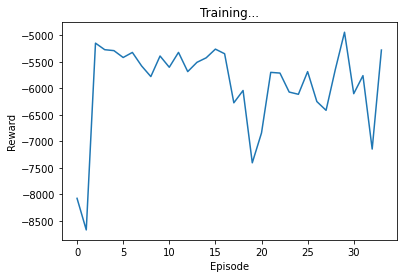

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -65.78993721746046
current_state2 [12.839673913043478, 16.09868283504077, 11.632573457252352, 23.21900701212387, 0, 1, 0, 1, 0, 0]
5
reward -69.16453031657477
current_state2 [12.839673913043478, 16.09868283504077, 12.792418063410366, 25.433755505080157, 0, 1, 0, 1, 0, 0]
5
reward -69.44378069808778
current_state2 [12.839673913043478, 16.545038981220323, 12.064348946546296, 25.99471885727769, 0, 1, 0, 1, 0, 0]
1
reward -68.27721560430516
current_state2 [12.839673913043478, 12.878946268032616, 15.674586987877081, 24.884008435351983, 0, 1, 0, 0, 1, 0]
1
reward -66.5443575851239
current_state2 [12.839673913043478, 12.878946268032616, 12.991729700627646, 25.83400770342016, 0, 1, 0, 0, 1, 0]
5
reward -59.69755393811913
current_state2 [11.413043478260871, 12.878946268032616, 11.989267071081885, 21.416297120743753, 0, 1, 0, 1, 0, 0]
5
reward -66.33658412704524
current_state2 [11.413043478260871, 12.878946268032616, 17.722555667575783, 22.32203871317597, 0, 0, 1, 1, 0, 0]
5
reward -67.12

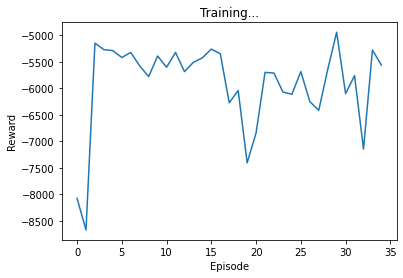

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -63.104204347554486
current_state2 [14.266304347826086, 14.688895201880166, 13.342343210983874, 18.806661586864365, 0, 1, 0, 0, 1, 0]
1
reward -59.57853800947411
current_state2 [14.266304347826086, 14.098477774077079, 13.858899476356124, 15.35485641121482, 0, 1, 0, 0, 1, 0]
1
reward -53.68819936510036
current_state2 [14.266304347826086, 12.878946268032616, 11.207136091584752, 13.335812657656911, 0, 1, 0, 0, 1, 0]
1
reward -67.48705418580477
current_state2 [14.266304347826086, 16.09868283504077, 15.363719275908833, 19.758347727029076, 0, 1, 0, 0, 1, 0]
1
reward -64.25697487673345
current_state2 [13.748209823407889, 14.971060874237626, 13.275684804216349, 20.26201937487159, 0, 1, 0, 0, 1, 0]
1
reward -59.900127770153205
current_state2 [12.839673913043478, 17.537903795096902, 10.126880839147113, 17.395669222865717, 0, 1, 0, 0, 1, 0]
1
reward -60.315158051225175
current_state2 [14.266304347826086, 13.857418664243127, 11.596000086884779, 18.595434952271184, 0, 0, 1, 0, 1, 0]
5
reward

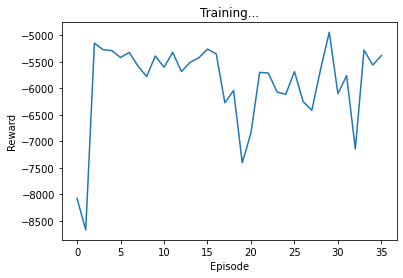

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -31.844716945263727
current_state2 [8.559782608695654, 12.878946268032616, 8.405988068535457, 0.0, 0, 1, 0, 0, 0, 1]
1
reward -27.8

reward -64.36547820959086
current_state2 [22.826086956521742, 9.65920970102446, 12.360213877091951, 17.519967674952706, 0, 1, 0, 1, 0, 0]
5
reward -78.22927091553174
current_state2 [25.67934782608696, 16.09868283504077, 16.919419122870323, 17.531821131533697, 0, 1, 0, 1, 0, 0]
1
reward -73.12371176412323
current_state2 [25.67934782608696, 16.09868283504077, 17.197726778650505, 12.147954324345, 0, 1, 0, 0, 1, 0]
1
reward -71.44705901742253
current_state2 [25.67934782608696, 15.147726608368902, 12.91602168930226, 15.703962893664396, 0, 1, 0, 0, 1, 0]
1
reward -65.51867912298178
current_state2 [25.67934782608696, 12.355667223855724, 12.466261355918029, 13.017402717121067, 0, 1, 0, 0, 1, 0]
1
reward -65.99398743050263
current_state2 [25.67934782608696, 9.963910734902036, 13.004403726874363, 15.346325142639268, 0, 1, 0, 0, 1, 0]
1
reward -67.04060389236508
current_state2 [25.67934782608696, 9.65920970102446, 11.195666720462231, 18.50637964479143, 0, 0, 1, 0, 1, 0]
5
reward -69.1605800279949

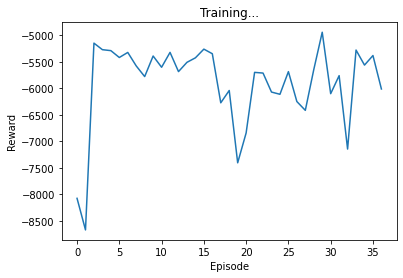

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -31.750186366384526
current_state2 [8.559782608695654, 12.878946268032616, 8.311457489656256, 0.0, 0, 1, 0, 0, 0, 1]
3
reward -30.8

reward -72.46329048635043
current_state2 [22.826086956521742, 12.878946268032616, 17.19982159372588, 17.5584356680702, 0, 1, 0, 0, 1, 0]
1
reward -64.71445809271975
current_state2 [22.826086956521742, 9.159963055259173, 14.783998158323422, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -57.76556156413211
current_state2 [22.826086956521742, 6.439473134016308, 12.56527172785076, 13.934729745743306, 0, 1, 0, 0, 1, 0]
1
reward -65.04950976364836
current_state2 [22.826086956521742, 9.65920970102446, 15.730513605412458, 14.83369950068971, 0, 1, 0, 0, 1, 0]
3
reward -71.24691773414997
current_state2 [23.803717361607614, 16.09868283504077, 17.072787758987886, 12.271729778513697, 0, 1, 0, 0, 0, 1]
1
reward -70.33940370500818
current_state2 [22.826086956521742, 16.01228931832124, 16.20893965576955, 13.292087774395645, 0, 1, 0, 0, 1, 0]
5
reward -70.76735497445512
current_state2 [22.826086956521742, 14.450018919758337, 15.98936248332925, 15.501886614845793, 0, 0, 1, 1, 0, 0]
5
reward -66.857256460

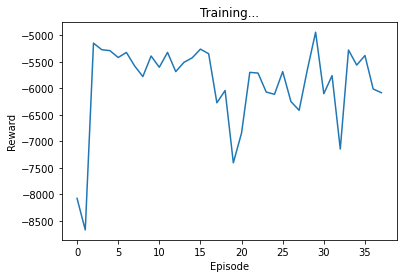

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.0918299842341
current_state2 [2.8532608695652177, 0.0, 7.238569114668882, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -14.704517485738425
current_state2 [4.279891304347826, 0.0, 8.424626181390598, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -18.150725359224047
current_state2 [5.7065217391304355, 3.219736567008154, 7.224467053085459, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.287474310326612
current_state2 [8.559782608695654, 6.439473134016308, 7.288218567614648, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -32.18730056892903
curr

reward -96.9306166575379
current_state2 [29.959239130434796, 6.439473134016308, 27.67326017975416, 30.858644213332628, 0, 1, 0, 1, 0, 0]
3
reward -95.62015961328945
current_state2 [29.959239130434796, 3.219736567008154, 29.17954668993396, 31.261637225912533, 0, 1, 0, 0, 0, 1]
3
reward -97.0193703907711
current_state2 [29.643413911186013, 6.439473134016308, 30.73129234810565, 28.20519099746313, 0, 1, 0, 0, 0, 1]
1
reward -97.38012019046218
current_state2 [29.959239130434796, 6.439473134016308, 30.768693009559968, 28.2127149164511, 0, 1, 0, 0, 1, 0]
3
reward -102.44362752072418
current_state2 [32.812500000000014, 6.439473134016308, 32.70535900898267, 28.486295377725185, 0, 1, 0, 0, 0, 1]
1
reward -99.28733744258525
current_state2 [32.812500000000014, 3.219736567008154, 34.006692672090864, 27.24840820348622, 0, 1, 0, 0, 1, 0]
1
reward -100.54396857366311
current_state2 [32.812500000000014, 3.219736567008154, 36.22367620701759, 26.288055799637352, 0, 0, 1, 0, 1, 0]
1
reward -100.2920931230

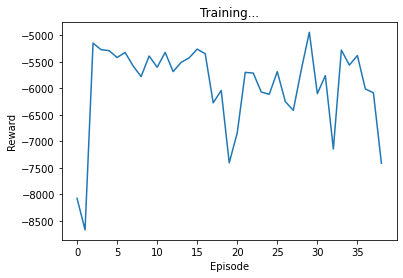

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -76.50287964474104
current_state2 [27.105978260869573, 14.59870922827005, 14.148833586527175, 18.64935856907425, 0, 1, 0, 1, 0, 0]
5
reward -74.93447641330357
current_state2 [27.105978260869573, 15.413035249698668, 14.47105298011991, 15.94440992261542, 0, 1, 0, 1, 0, 0]
5
reward -76.55138817697835
current_state2 [27.105978260869573, 16.15478039750543, 14.973356628499442, 16.31727289010391, 0, 1, 0, 1, 0, 0]
5
reward -87.16597031344486
current_state2 [27.105978260869573, 19.465780307685616, 21.19854252202395, 17.395669222865717, 0, 1, 0, 1, 0, 0]
5
reward -89.16041826235137
current_state2 [28.532608695652183, 22.08036408325812, 19.899196806121036, 16.648248677320026, 0, 1, 0, 1, 0, 0]
5
reward -88.40109160130046
current_state2 [28.532608695652183, 22.008160435196753, 19.75720646374874, 16.1031160067028, 0, 1, 0, 1, 0, 0]
1
reward -83.85763659590386
current_state2 [28.532608695652183, 18.359436198406534, 19.021181779229718, 15.94440992261542, 0, 0, 1, 0, 1, 0]
1
reward -79.6515143

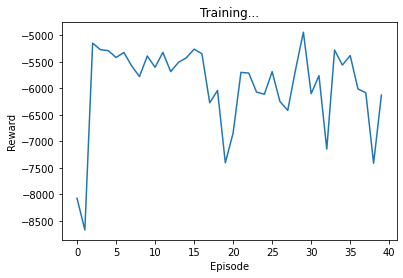

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -25.812808006843245
current_state2 [7.133152173913045, 9.65920970102446, 7.02044613190574, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -23.95591

reward -73.77203199562409
current_state2 [18.54619565217391, 14.463091621744201, 14.02839678012288, 24.734347941583092, 0, 1, 0, 1, 0, 0]
5
reward -76.14218658289437
current_state2 [18.54619565217391, 16.09868283504077, 15.222040730502902, 24.275267365176774, 0, 1, 0, 1, 0, 0]
5
reward -73.98870478017574
current_state2 [18.54619565217391, 16.09868283504077, 16.27547692599362, 21.06834936696744, 0, 1, 0, 1, 0, 0]
5
reward -74.45202337973402
current_state2 [17.1195652173913, 15.219513301708218, 16.010753048203977, 24.10219181243052, 0, 1, 0, 1, 0, 0]
1
reward -73.21911202339322
current_state2 [17.1195652173913, 16.09868283504077, 18.08307075471755, 19.91779321624359, 0, 1, 0, 0, 1, 0]
1
reward -74.0828871456969
current_state2 [17.1195652173913, 13.649169330778685, 17.54085458410064, 23.773298013426267, 0, 1, 0, 0, 1, 0]
1
reward -73.99333198646407
current_state2 [17.1195652173913, 16.09868283504077, 14.547092593346658, 24.227991340685332, 0, 0, 1, 0, 1, 0]
1
reward -71.83900266322071
cur

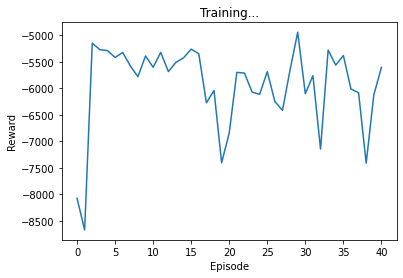

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -29.23

reward -75.32442840485947
current_state2 [22.826086956521742, 8.629135011490556, 21.48983640342153, 20.379370033425637, 0, 1, 0, 1, 0, 0]
5
reward -74.4474083710722
current_state2 [24.25271739130435, 12.878946268032616, 19.10428541952624, 16.211459292209003, 0, 1, 0, 1, 0, 0]
5
reward -71.40135844893035
current_state2 [23.121218182278167, 16.09868283504077, 18.640894856773343, 11.540562574838079, 0, 1, 0, 1, 0, 0]
5
reward -77.00634355353003
current_state2 [22.826086956521742, 16.09868283504077, 23.33287898523687, 12.748694776730645, 0, 1, 0, 1, 0, 0]
5
reward -77.6392390621481
current_state2 [22.826086956521742, 17.13201121243663, 23.409411114676033, 12.271729778513697, 0, 1, 0, 1, 0, 0]
5
reward -75.07183664745139
current_state2 [22.826086956521742, 16.09868283504077, 21.71065051768162, 12.436416338207266, 0, 1, 0, 1, 0, 0]
5
reward -81.11053943615184
current_state2 [22.826086956521742, 15.375647982482496, 23.710705228323647, 17.19809926882395, 0, 0, 1, 1, 0, 0]
5
reward -81.28538929

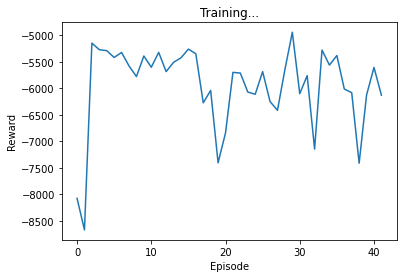

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -59.68102038008527
current_state2 [12.839673913043478, 14.385816097410586, 15.857086178520781, 14.598444191110426, 0, 1, 0, 0, 1, 0]
1
reward -52.61085291616724
current_state2 [12.839673913043478, 9.65920970102446, 12.419463789493461, 15.69250551260584, 0, 1, 0, 0, 1, 0]
1
reward -45.81930480348814
current_state2 [12.839673913043478, 6.439473134016308, 14.973376624373476, 9.566781132054869, 0, 1, 0, 0, 1, 0]
1
reward -43.82644989145607
current_state2 [12.839673913043478, 6.439473134016308, 10.213266714615019, 12.334036129781268, 0, 1, 0, 0, 1, 0]
1
reward -55.41430042697477
current_state2 [14.266304347826086, 12.878946268032616, 11.435350310426355, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -53.8976469897998
current_state2 [14.266304347826086, 16.025798101675644, 9.333814761784376, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -60.3273772233392
current_state2 [14.266304347826086, 18.184472299619447, 9.932190653278237, 15.94440992261542, 0, 0, 1, 0, 1, 0]
5
reward -54.3995335

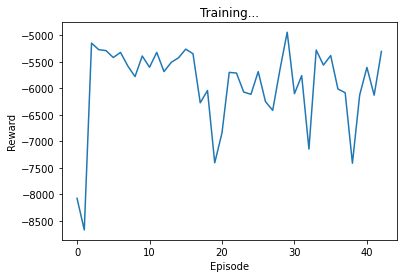

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -62.92436922109283
current_state2 [17.1195652173913, 15.693574069508978, 12.100951264950524, 16.010278669242027, 0, 1, 0, 0, 1, 0]
1
reward -56.44728128363996
current_state2 [17.1195652173913, 9.65920970102446, 11.782262223940124, 15.886244141284076, 0, 1, 0, 0, 1, 0]
1
reward -52.66866385535105
current_state2 [15.692934782608695, 9.65920970102446, 10.845452387049766, 14.471066984668125, 0, 1, 0, 0, 1, 0]
5
reward -62.07268440132795
current_state2 [15.692934782608695, 12.878946268032616, 15.556393428071214, 15.94440992261542, 0, 1, 0, 1, 0, 0]
1
reward -65.54873871387935
current_state2 [17.1195652173913, 16.09868283504077, 12.668432473064568, 17.662058188382698, 0, 1, 0, 0, 1, 0]
1
reward -50.74828429900561
current_state2 [17.1195652173913, 6.439473134016308, 11.949784671441407, 13.239461276156595, 0, 1, 0, 0, 1, 0]
1
reward -50.27904877581659
current_state2 [17.1195652173913, 3.219736567008154, 11.853229851146383, 16.086517140270754, 0, 0, 1, 0, 1, 0]
1
reward -50.4055302202843

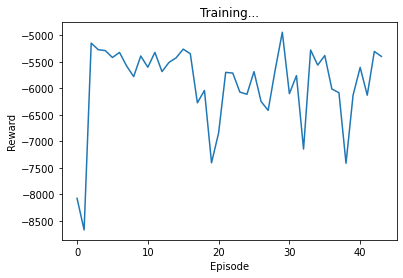

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -26.399147544496568
current_state2 [7.133152173913045, 9.65920970102446, 7.606785669559063, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -24.0159

reward -47.56360177979142
current_state2 [11.413043478260871, 9.65920970102446, 11.611496977902597, 12.879851622603487, 0, 1, 0, 0, 1, 0]
1
reward -48.36899621091979
current_state2 [11.50311578785503, 9.65920970102446, 8.930313965285535, 16.276356756754765, 0, 1, 0, 0, 1, 0]
1
reward -55.487199538410785
current_state2 [12.839673913043478, 12.878946268032616, 12.934879856644983, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -56.03646218612939
current_state2 [12.839673913043478, 16.09868283504077, 10.526418135796458, 14.571687302248684, 0, 1, 0, 0, 1, 0]
3
reward -46.806084759072796
current_state2 [12.839673913043478, 9.65920970102446, 10.035471366491162, 12.271729778513697, 0, 1, 0, 0, 0, 1]
1
reward -52.50642778800823
current_state2 [11.413043478260871, 12.878946268032616, 14.378861086414746, 11.835576955299997, 0, 1, 0, 0, 1, 0]
1
reward -47.56917131229482
current_state2 [11.413043478260871, 9.65920970102446, 11.114477932570075, 13.38244020043941, 0, 0, 1, 0, 1, 0]
1
reward -45.542249

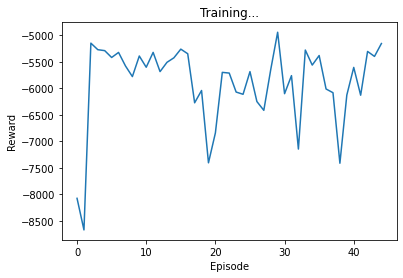

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -60.12387655114128
current_state2 [19.972826086956523, 16.09868283504077, 9.780637850630294, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -60.571289312930105
current_state2 [19.972826086956523, 12.878946268032616, 13.167214876473393, 12.552302081467575, 0, 1, 0, 0, 1, 0]
1
reward -59.697185489415
current_state2 [19.972826086956523, 12.878946268032616, 12.57368335591217, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -55.02748613664158
current_state2 [19.972826086956523, 9.65920970102446, 11.123720570146899, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -53.28435385296673
current_state2 [19.972826086956523, 12.878946268032616, 9.407998828023995, 9.024582669953599, 0, 1, 0, 0, 1, 0]
1
reward -61.07920188231961
current_state2 [21.399456521739133, 14.284043840667856, 12.80183345041796, 10.59386806949466, 0, 1, 0, 0, 1, 0]
1
reward -59.88101901989991
current_state2 [21.399456521739133, 12.878946268032616, 10.22017602968875, 13.38244020043941, 0, 0, 1, 0, 1, 0]
1
reward -55.7272049

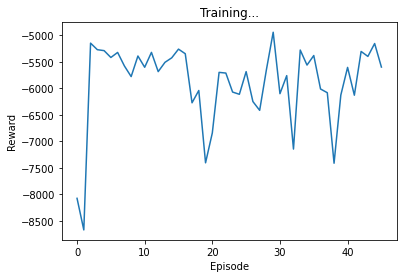

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -30.74788272804807
current_state2 [8.559782608695654, 12.878946268032616, 7.309153851319798, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -25.67

reward -73.0718606412797
current_state2 [18.54619565217391, 12.878946268032616, 17.86062793057107, 21.786090790502104, 0, 1, 0, 0, 1, 0]
1
reward -67.21281670733806
current_state2 [17.1195652173913, 12.878946268032616, 14.845948501465427, 20.36835672044872, 0, 1, 0, 0, 1, 0]
1
reward -56.21105440019937
current_state2 [17.1195652173913, 9.65920970102446, 11.045680614265358, 16.38659886751825, 0, 1, 0, 0, 1, 0]
1
reward -61.676586702144455
current_state2 [17.1195652173913, 12.878946268032616, 13.733665294105114, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -62.68444379202937
current_state2 [17.1195652173913, 14.239009749466469, 12.296648378299821, 17.02922044687178, 0, 1, 0, 0, 1, 0]
1
reward -57.22715196769119
current_state2 [17.1195652173913, 14.209936078893085, 9.051684967301497, 14.845965704105309, 0, 1, 0, 0, 1, 0]
5
reward -63.286201806773576
current_state2 [17.1195652173913, 9.65920970102446, 12.902115704097286, 21.605311184260525, 0, 0, 1, 1, 0, 0]
1
reward -61.09131908426276
cu

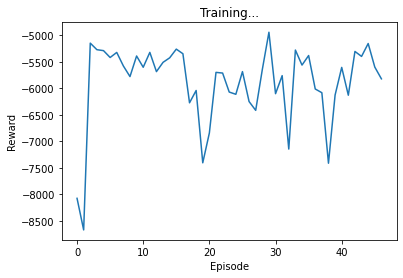

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.0918299842341
current_state2 [2.8532608695652177, 0.0, 7.238569114668882, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -14.54791684553889
current_state2 [4.279891304347826, 0.0, 8.268025541191063, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -18.563151032215515
current_state2 [5.742835196761785, 3.219736567008154, 7.600579268445576, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.68104810097702
current_state2 [8.559782608695654, 6.439473134016308, 7.6817923582650565, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -30.16059081182819
curren

reward -72.7533485943517
current_state2 [19.972826086956523, 9.65920970102446, 15.045952715116364, 26.075360091254357, 0, 1, 0, 0, 1, 0]
1
reward -74.30506956243006
current_state2 [19.972826086956523, 12.878946268032616, 14.043734788607757, 25.409562418833172, 0, 1, 0, 0, 1, 0]
1
reward -71.90290897187701
current_state2 [21.399456521739133, 12.878946268032616, 10.921769378342251, 24.70273680376302, 0, 1, 0, 0, 1, 0]
1
reward -74.27959317465773
current_state2 [21.399456521739133, 12.41875248202231, 13.409615789677389, 25.05176838121891, 0, 1, 0, 0, 1, 0]
1
reward -69.39729614458463
current_state2 [21.399456521739133, 9.894477962174987, 13.781322947494536, 22.32203871317597, 0, 1, 0, 0, 1, 0]
1
reward -71.31146953050613
current_state2 [21.399456521739133, 14.788633122921663, 11.912051594595088, 21.211328291250258, 0, 1, 0, 0, 1, 0]
1
reward -69.3477315061881
current_state2 [21.399456521739133, 16.09868283504077, 11.343212504616769, 18.50637964479143, 0, 0, 1, 0, 1, 0]
5
reward -70.505465

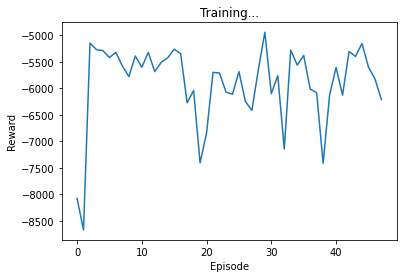

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -23.02101192614445
current_state2 [6.402675905359066, 6.439473134016308, 8.178862886769075, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -31.92571219196154
current_state2 [8.559782608695654, 12.878946268032616, 8.486983315233271, 0.0, 0, 1, 0, 0, 1, 0]
3
reward -27.592

reward -62.39741546574582
current_state2 [18.684852933766496, 9.65920970102446, 17.15159289927245, 14.901759931682413, 0, 1, 0, 0, 1, 0]
1
reward -70.55345931178614
current_state2 [21.399456521739133, 12.878946268032616, 16.71776699427467, 17.557289527739723, 0, 1, 0, 0, 1, 0]
1
reward -57.89358933757836
current_state2 [21.399456521739133, 9.65920970102446, 13.816882682509599, 11.018040432305169, 0, 1, 0, 0, 1, 0]
1
reward -58.60103052499439
current_state2 [19.972826086956523, 9.65920970102446, 12.333089902654358, 14.635904834359053, 0, 1, 0, 0, 1, 0]
1
reward -64.0762695246577
current_state2 [19.972826086956523, 9.65920970102446, 13.79487516760247, 18.64935856907425, 0, 1, 0, 0, 1, 0]
1
reward -67.57944239023215
current_state2 [19.972826086956523, 16.09868283504077, 13.563523545619427, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -67.37544116131546
current_state2 [21.399456521739133, 16.09868283504077, 12.345669779857484, 15.531632024678073, 0, 0, 1, 0, 1, 0]
1
reward -66.74247163681

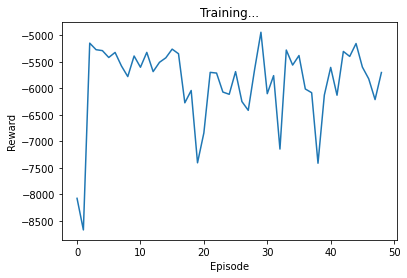

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -70.33532101514565
current_state2 [19.972826086956523, 17.632306391251337, 13.465127781209734, 17.26506075572806, 0, 1, 0, 0, 1, 0]
1
reward -71.91535696689004
current_state2 [19.972826086956523, 18.48871126982416, 12.35977879301189, 19.09404081709748, 0, 1, 0, 0, 1, 0]
1
reward -59.766018717955426
current_state2 [18.54619565217391, 14.738228617474517, 11.266003811806304, 13.2155906365007, 0, 1, 0, 0, 1, 0]
1
reward -63.89381576136556
current_state2 [18.54619565217391, 16.09868283504077, 11.516225648393053, 15.732711625757824, 0, 1, 0, 0, 1, 0]
1
reward -64.01552349161817
current_state2 [18.54619565217391, 16.09868283504077, 9.327606187470634, 18.043038816932846, 0, 1, 0, 0, 1, 0]
1
reward -62.53766847614637
current_state2 [18.54619565217391, 16.09868283504077, 12.334840924542938, 13.557949064388753, 0, 1, 0, 0, 1, 0]
3
reward -67.54728112899632
current_state2 [19.972826086956523, 16.09868283504077, 12.27767293817507, 17.19809926882395, 0, 0, 1, 0, 0, 1]
3
reward -61.96077686018

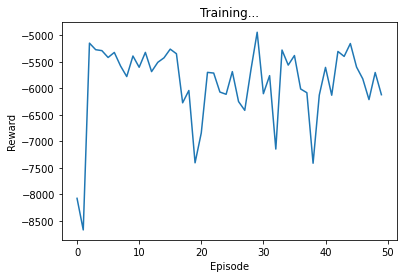

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -68.8468950936295
current_state2 [17.1195652173913, 16.09868283504077, 9.39574376403671, 24.232903277160716, 0, 1, 0, 0, 1, 0]
1
reward -71.0984824768577
current_state2 [17.1195652173913, 16.09868283504077, 13.398583640485933, 22.48165078393969, 0, 1, 0, 0, 1, 0]
1
reward -60.84775405443032
current_state2 [15.87158881482504, 12.878946268032616, 11.59083932678123, 18.50637964479143, 0, 1, 0, 0, 1, 0]
1
reward -60.82945192072293
current_state2 [15.692934782608695, 9.65920970102446, 11.656897832817668, 21.820409604272104, 0, 1, 0, 0, 1, 0]
1
reward -62.3642559257995
current_state2 [15.692934782608695, 12.878946268032616, 10.73670930788697, 21.055665567271216, 0, 1, 0, 0, 1, 0]
5
reward -61.08117781255884
current_state2 [15.692934782608695, 12.878946268032616, 15.686414150968092, 14.822882610949442, 0, 1, 0, 1, 0, 0]
1
reward -67.61385803891437
current_state2 [17.1195652173913, 12.878946268032616, 16.398421370250063, 19.216925183240395, 0, 0, 1, 0, 1, 0]
5
reward -62.13840825842053


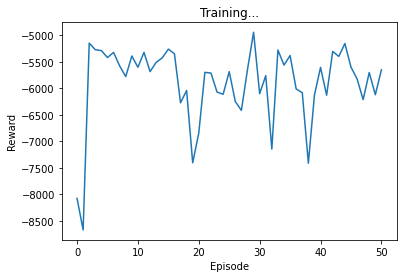

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -58.66982506598568
current_state2 [12.839673913043478, 9.65920970102446, 14.068100896818216, 20.102840555099522, 0, 1, 0, 0, 1, 0]
1
reward -62.710971279932224
current_state2 [12.839673913043478, 12.481753992881735, 13.202441168915133, 22.18710220509188, 0, 1, 0, 0, 1, 0]
1
reward -57.497946715047476
current_state2 [12.039562551968306, 13.684578380287569, 11.267426138000172, 18.50637964479143, 0, 1, 0, 0, 1, 0]
1
reward -56.740991888849024
current_state2 [11.413043478260871, 12.878946268032616, 8.752013140559743, 21.69698900199579, 0, 1, 0, 0, 1, 0]
3
reward -67.0368988609653
current_state2 [11.413043478260871, 16.09868283504077, 15.91032927839304, 21.614843269270622, 0, 1, 0, 0, 0, 1]
3
reward -58.47090254280606
current_state2 [11.413043478260871, 12.878946268032616, 16.377481798179968, 15.801430998332604, 0, 1, 0, 0, 0, 1]
1
reward -60.9701605914928
current_state2 [12.367317607366267, 13.77285335439431, 15.631890360908265, 17.19809926882395, 0, 0, 1, 0, 1, 0]
1
reward -57.1352

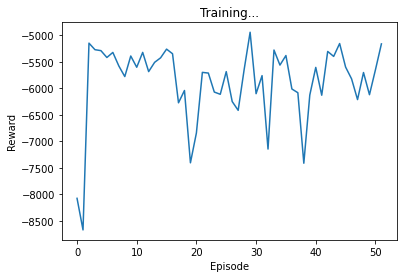

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -48.92451397613093
current_state2 [18.54619565217391, 3.219736567008154, 11.344308461141601, 13.814273295807263, 0, 1, 0, 0, 1, 0]
1
reward -55.518845119967324
current_state2 [19.972826086956523, 3.219736567008154, 14.381872543387221, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -54.24327107004951
current_state2 [21.399456521739133, 9.65920970102446, 11.617823715231049, 9.566781132054869, 0, 1, 0, 0, 1, 0]
1
reward -65.36068384474672
current_state2 [22.826086956521742, 16.09868283504077, 10.887134837565934, 13.548779215618262, 0, 1, 0, 0, 1, 0]
5
reward -69.71526695699032
current_state2 [22.826086956521742, 16.09868283504077, 12.197188736904828, 16.593308428522977, 0, 1, 0, 1, 0, 0]
5
reward -65.20965853346198
current_state2 [22.826086956521742, 16.09868283504077, 13.033831240904295, 11.251057500995174, 0, 1, 0, 1, 0, 0]
1
reward -66.81073010557137
current_state2 [22.826086956521742, 14.520282760070769, 13.767314587088459, 13.697045801890392, 0, 0, 1, 0, 1, 0]
5
reward -65.3820

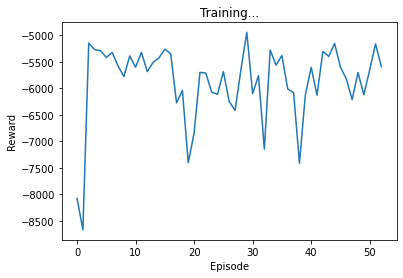

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -81.4856415117487
current_state2 [18.48839317667097, 9.65920970102446, 26.526524602365637, 24.81151403168762, 0, 1, 0, 0, 1, 0]
1
reward -75.9171016094997
current_state2 [18.54619565217391, 8.728038834644861, 24.161012073502263, 22.481855049178666, 0, 1, 0, 0, 1, 0]
1
reward -72.10925570915323
current_state2 [18.54619565217391, 3.219736567008154, 27.131995198720915, 21.211328291250258, 0, 1, 0, 0, 1, 0]
1
reward -71.69904655899842
current_state2 [19.678236258915064, 6.439473134016308, 23.683631149292655, 19.897706016774393, 0, 1, 0, 0, 1, 0]
1
reward -70.36974861186735
current_state2 [19.972826086956523, 9.65920970102446, 19.28240853497342, 19.455304288912956, 0, 1, 0, 0, 1, 0]
1
reward -77.39722172983097
current_state2 [22.826086956521742, 16.09868283504077, 15.07036817775298, 21.402083760515477, 0, 1, 0, 0, 1, 0]
1
reward -77.01874491860934
current_state2 [22.826086956521742, 16.09868283504077, 15.885552869786832, 20.208422257259997, 0, 0, 1, 0, 1, 0]
1
reward -79.814358655354

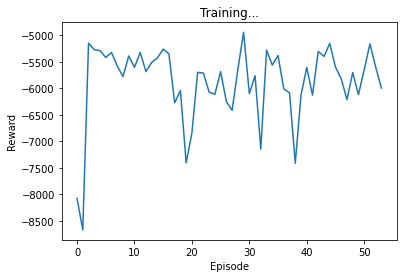

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.3959

reward -65.98317179659682
current_state2 [14.266304347826086, 16.09868283504077, 8.591197254095164, 25.0269873596348, 0, 1, 0, 0, 1, 0]
1
reward -69.81158314970271
current_state2 [14.266304347826086, 12.878946268032616, 14.5286347522835, 26.137697781560508, 0, 1, 0, 0, 1, 0]
5
reward -65.3985217411229
current_state2 [14.266304347826086, 12.878946268032616, 13.931232412088232, 22.32203871317597, 0, 1, 0, 1, 0, 0]
1
reward -62.81580943635905
current_state2 [14.266304347826086, 13.478461140197926, 12.613909058386778, 20.457134889948254, 0, 1, 0, 0, 1, 0]
1
reward -54.964395673879594
current_state2 [13.968828357969498, 9.65920970102446, 13.68264414950267, 15.653713465382962, 0, 1, 0, 0, 1, 0]
1
reward -51.823927308387916
current_state2 [12.839673913043478, 6.439473134016308, 14.911163912780992, 15.633616348547136, 0, 1, 0, 0, 1, 0]
1
reward -52.283968891986056
current_state2 [12.839673913043478, 6.439473134016308, 12.525661212735283, 18.479160632190986, 0, 0, 1, 0, 1, 0]
1
reward -53.78291

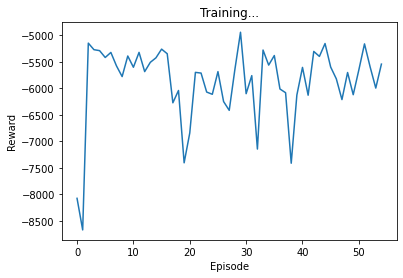

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -30.74788272804807
current_state2 [8.559782608695654, 12.878946268032616, 7.309153851319798, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -25.67

reward -92.35740245277825
current_state2 [32.812500000000014, 16.09868283504077, 20.234891326487205, 21.211328291250258, 0, 1, 0, 0, 0, 1]
5
reward -91.94642235079532
current_state2 [32.812500000000014, 16.09868283504077, 20.985399703434204, 20.04983981232033, 0, 1, 0, 1, 0, 0]
5
reward -85.91824803525849
current_state2 [31.513625393577772, 12.878946268032616, 21.479608241293157, 18.046068132354936, 0, 1, 0, 1, 0, 0]
5
reward -81.51742919232443
current_state2 [31.3858695652174, 6.439473134016308, 22.473981383610244, 19.21810510948048, 0, 1, 0, 1, 0, 0]
5
reward -80.01954050767513
current_state2 [31.3858695652174, 6.84088807191072, 20.685089215555042, 19.10769365499196, 0, 1, 0, 1, 0, 0]
5
reward -82.61533001732784
current_state2 [31.3858695652174, 9.65920970102446, 22.475984306659406, 17.094266444426562, 0, 1, 0, 1, 0, 0]
5
reward -95.72620379739351
current_state2 [34.23913043478262, 16.09868283504077, 23.526327293516573, 19.862063234053547, 0, 0, 1, 1, 0, 0]
5
reward -97.0765179260298

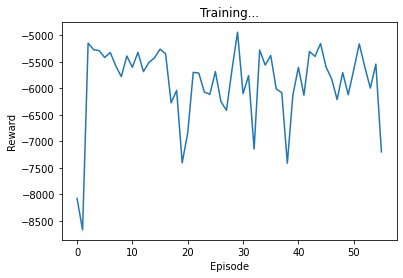

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
3
reward -29.4282

reward -63.02541988504238
current_state2 [17.1195652173913, 16.09868283504077, 12.962313463010103, 14.844858369600205, 0, 1, 0, 0, 1, 0]
5
reward -60.26092881463754
current_state2 [17.1195652173913, 12.952957842117248, 13.695255132763865, 14.493150622365121, 0, 1, 0, 1, 0, 0]
1
reward -49.83083026876728
current_state2 [17.1195652173913, 9.65920970102446, 13.017431370749762, 8.034623979601756, 0, 1, 0, 0, 1, 0]
1
reward -49.93468694944636
current_state2 [17.1195652173913, 6.485312110898829, 14.620049564818544, 9.709760056337686, 0, 1, 0, 0, 1, 0]
5
reward -61.491570665218646
current_state2 [18.54619565217391, 6.439473134016308, 17.261965222817672, 17.243936656210753, 0, 1, 0, 1, 0, 0]
1
reward -55.403704796817756
current_state2 [18.54619565217391, 6.439473134016308, 16.35763035732127, 12.060405653306267, 0, 1, 0, 0, 1, 0]
5
reward -54.114245043201315
current_state2 [18.54619565217391, 6.439473134016308, 15.715423207240665, 11.413153049770436, 0, 0, 1, 1, 0, 0]
1
reward -61.8363403900224

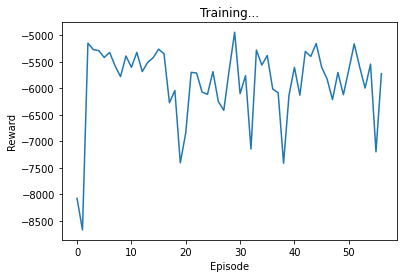

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -55.752163201595735
current_state2 [14.862000322460952, 3.219736567008154, 18.07078282865553, 17.599643483471095, 0, 1, 0, 0, 1, 0]
5
reward -62.999332341120194
current_state2 [17.1195652173913, 1.8391985472311536, 21.69774120623709, 20.342827370260654, 0, 1, 0, 1, 0, 0]
1
reward -61.23292704782746
current_state2 [18.54619565217391, 0.0, 21.443172423234316, 19.24355897241924, 0, 1, 0, 0, 1, 0]
1
reward -60.96733377428412
current_state2 [19.972826086956523, 3.219736567008154, 17.6228337593067, 18.15193736101274, 0, 1, 0, 0, 1, 0]
1
reward -64.77224789100497
current_state2 [22.826086956521742, 6.439473134016308, 20.105072798744228, 13.40161500172269, 0, 1, 0, 0, 1, 0]
5
reward -72.60862366316567
current_state2 [24.25271739130435, 10.44074620934383, 21.08146056182779, 14.83369950068971, 0, 1, 0, 1, 0, 0]
1
reward -71.98644996074951
current_state2 [24.25271739130435, 10.157657953992183, 19.930044454731338, 15.646030160721631, 0, 0, 1, 0, 1, 0]
1
reward -76.92578725030424
current_sta

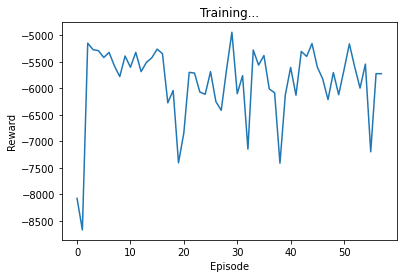

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -75.76906200207584
current_state2 [28.532608695652183, 12.878946268032616, 16.53681159602506, 15.820695442365986, 0, 1, 0, 0, 0, 1]
1
reward -75.26809384657395
current_state2 [28.532608695652183, 10.92046114809629, 17.87061408021005, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -71.6920787718418
current_state2 [28.532608695652183, 12.878946268032616, 16.00879402964331, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -65.66463866560161
current_state2 [28.532608695652183, 9.65920970102446, 13.201090490411268, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -65.08763492126872
current_state2 [28.532608695652183, 8.165645302140584, 15.568910445212556, 10.820470478263397, 0, 1, 0, 0, 1, 0]
1
reward -62.520276771751625
current_state2 [27.105978260869573, 9.65920970102446, 10.666245921587166, 13.088842888270419, 0, 1, 0, 0, 1, 0]
1
reward -69.36823858559363
current_state2 [28.532608695652183, 15.157240204954213, 9.10296656655747, 14.57542311842977, 0, 0, 1, 0, 1, 0]
1
reward -70.97976898

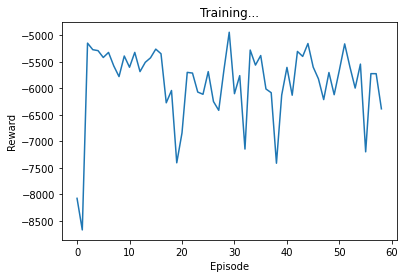

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -74.64528567363104
current_state2 [21.399456521739133, 15.719510525200386, 12.747320365780634, 22.778998260910885, 0, 1, 0, 0, 1, 0]
1
reward -75.61566432972425
current_state2 [21.399456521739133, 16.09868283504077, 12.528331774315962, 23.589193198628394, 0, 1, 0, 0, 1, 0]
3
reward -73.71696420527893
current_state2 [20.133887030428372, 16.09868283504077, 14.416044972842347, 21.06834936696744, 0, 1, 0, 0, 0, 1]
1
reward -75.62910971315738
current_state2 [19.972826086956523, 16.09868283504077, 15.235562077984113, 22.32203871317597, 0, 1, 0, 0, 1, 0]
1
reward -72.79190329978006
current_state2 [19.972826086956523, 16.09868283504077, 12.611148217251953, 22.109246160530812, 0, 1, 0, 0, 1, 0]
1
reward -69.48138017414777
current_state2 [19.972826086956523, 16.687356627959176, 15.525397611256919, 15.295799847975152, 0, 1, 0, 0, 1, 0]
1
reward -65.61771429770798
current_state2 [19.972826086956523, 12.878946268032616, 13.823713847776183, 16.942228094942653, 0, 0, 1, 0, 1, 0]
1
reward -66.9

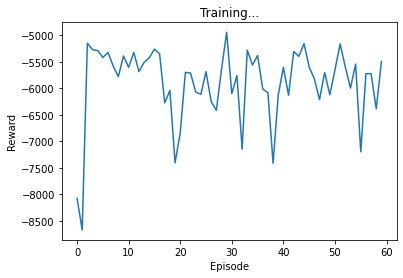

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -65.27153921870554
current_state2 [17.1195652173913, 12.878946268032616, 10.74410442441432, 22.52892330886731, 0, 1, 0, 1, 0, 0]
5
reward -68.71224117326744
current_state2 [17.1195652173913, 12.878946268032616, 16.12799799089828, 20.585731696945253, 0, 1, 0, 1, 0, 0]
5
reward -59.30998338224657
current_state2 [15.778989299649387, 9.65920970102446, 15.114955455792673, 16.756828925780052, 0, 1, 0, 1, 0, 0]
5
reward -61.678828697289276
current_state2 [15.692934782608695, 9.65920970102446, 15.166998672879084, 19.159685540777037, 0, 1, 0, 1, 0, 0]
5
reward -63.622976892733476
current_state2 [15.692934782608695, 10.260205382531067, 15.460252157874226, 20.209584569719485, 0, 1, 0, 1, 0, 0]
1
reward -64.81213556941516
current_state2 [15.692934782608695, 12.878946268032616, 18.438823520441243, 15.801430998332604, 0, 1, 0, 0, 1, 0]
1
reward -66.02019305798785
current_state2 [17.1195652173913, 11.52132513171334, 16.35676599025031, 19.0225367186329, 0, 0, 1, 0, 1, 0]
1
reward -61.3626809549

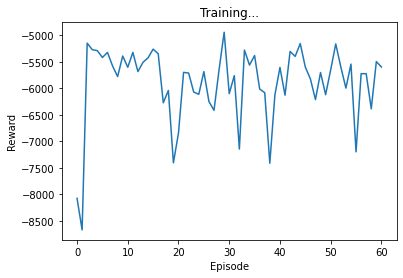

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -28.

reward -79.23443307463121
current_state2 [18.54619565217391, 12.878946268032616, 22.084996528457136, 23.72429462596754, 0, 1, 0, 0, 1, 0]
1
reward -81.09539300056679
current_state2 [18.54619565217391, 13.035190353459727, 20.910233354914855, 26.603773640018293, 0, 1, 0, 0, 1, 0]
1
reward -79.12547551684172
current_state2 [18.54619565217391, 12.878946268032616, 19.335579175441087, 26.364754421194107, 0, 1, 0, 0, 1, 0]
3
reward -83.8970977981933
current_state2 [17.1195652173913, 12.878946268032616, 23.19891880903286, 28.69966750373652, 0, 1, 0, 0, 0, 1]
1
reward -85.51027768760943
current_state2 [18.21643631644427, 16.09868283504077, 24.533417622915355, 24.66174091320904, 0, 1, 0, 0, 1, 0]
1
reward -78.41596820479243
current_state2 [18.54619565217391, 10.327316757706077, 22.86569186049764, 24.67676393441481, 0, 1, 0, 0, 1, 0]
1
reward -69.66839660627278
current_state2 [18.54619565217391, 3.219736567008154, 20.061608449136543, 25.840855937954178, 0, 0, 1, 0, 1, 0]
1
reward -68.543273643736

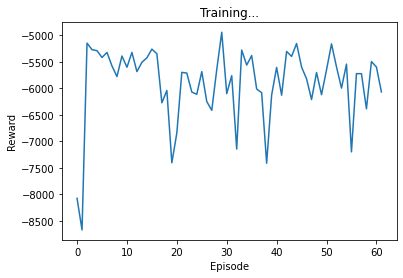

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
1
reward -25.25

reward -65.64896119381898
current_state2 [22.826086956521742, 6.439473134016308, 16.690456849246715, 17.69294425403422, 0, 1, 0, 1, 0, 0]
1
reward -70.16643298660243
current_state2 [22.403856684802783, 9.65920970102446, 15.827941127792409, 20.27542547298278, 0, 1, 0, 0, 1, 0]
1
reward -69.77387298791206
current_state2 [22.826086956521742, 11.573573425000525, 13.581202891092605, 19.79300971529719, 0, 1, 0, 0, 1, 0]
5
reward -69.32586172082371
current_state2 [22.826086956521742, 6.439473134016308, 21.383332874309616, 16.67696875597605, 0, 1, 0, 1, 0, 0]
5
reward -64.45724752447616
current_state2 [22.826086956521742, 6.439473134016308, 19.648408413258576, 13.543279020679533, 0, 1, 0, 1, 0, 0]
5
reward -66.7149881331317
current_state2 [22.826086956521742, 6.439473134016308, 18.924159306687685, 16.525268735905964, 0, 1, 0, 1, 0, 0]
5
reward -76.01921968379824
current_state2 [24.25271739130435, 9.65920970102446, 20.814444182594517, 19.29284840887492, 0, 0, 1, 1, 0, 0]
5
reward -75.2958476707

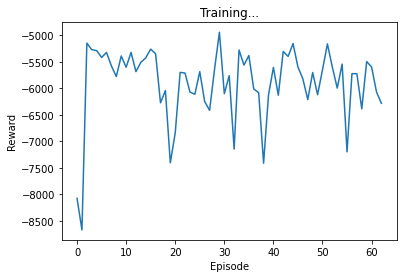

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -68.04162051314306
current_state2 [15.692934782608695, 16.09868283504077, 20.263071139648666, 13.98693175584493, 0, 1, 0, 1, 0, 0]
5
reward -65.19300662849443
current_state2 [15.692934782608695, 12.878946268032616, 19.668151708108216, 14.9529738697449, 0, 1, 0, 1, 0, 0]
5
reward -64.16505245815719
current_state2 [15.692934782608695, 11.6274947382782, 23.62061161044053, 11.22401132682977, 0, 1, 0, 1, 0, 0]
5
reward -63.20501238439041
current_state2 [15.692934782608695, 11.025399044142064, 22.214948779125955, 12.271729778513697, 0, 1, 0, 1, 0, 0]
1
reward -63.18571856294231
current_state2 [14.266304347826086, 16.09868283504077, 18.984199423250907, 11.83653195682455, 0, 1, 0, 0, 1, 0]
5
reward -70.11827630282045
current_state2 [15.692934782608695, 16.88798165823019, 24.25272990643559, 11.284629955545967, 0, 1, 0, 1, 0, 0]
1
reward -67.49674339797426
current_state2 [15.692934782608695, 13.900653012297779, 22.5516240796322, 13.351531523435588, 0, 0, 1, 0, 1, 0]
5
reward -61.721429135

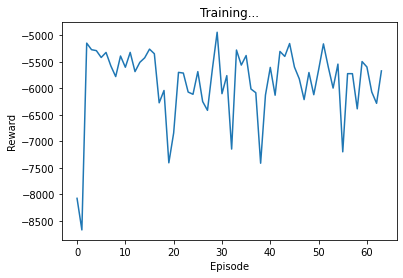

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -61.482554857297146
current_state2 [17.1195652173913, 16.09868283504077, 13.992577026351377, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -55.3616402574145
current_state2 [17.1195652173913, 11.499192976926544, 11.753597285666029, 12.989284777430624, 0, 1, 0, 0, 1, 0]
1
reward -54.84931013297836
current_state2 [17.1195652173913, 12.878946268032616, 11.701202504776465, 11.14959614277798, 0, 1, 0, 0, 1, 0]
3
reward -62.881602295306486
current_state2 [17.1195652173913, 16.09868283504077, 15.391624464360717, 12.271729778513697, 0, 1, 0, 0, 0, 1]
1
reward -61.110066924587386
current_state2 [16.153743034942178, 14.169660689970568, 15.555408855039353, 13.231254344635289, 0, 1, 0, 0, 1, 0]
1
reward -50.53817137099125
current_state2 [15.692934782608695, 9.65920970102446, 12.601328678117653, 10.584698209240441, 0, 1, 0, 0, 1, 0]
5
reward -55.844349428923564
current_state2 [15.692934782608695, 6.439473134016308, 15.191053029046566, 16.520888483251998, 0, 0, 1, 1, 0, 0]
1
reward -47.851619

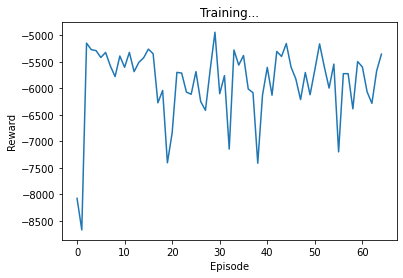

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
3
reward -29.

current_state2 [29.959239130434796, 19.31841940204892, 16.435323035767535, 26.916654144646163, 0, 1, 0, 0, 1, 0]
1
reward -96.72383056758235
current_state2 [31.3858695652174, 18.866618518560323, 17.024191251030093, 27.44715123277454, 0, 1, 0, 0, 1, 0]
1
reward -93.95606801209735
current_state2 [29.959239130434796, 17.157179762921242, 15.9640493973934, 28.875599721347914, 0, 1, 0, 0, 1, 0]
1
reward -92.80443399459956
current_state2 [29.959239130434796, 16.09868283504077, 14.545155726954192, 30.201356302169803, 0, 1, 0, 0, 1, 0]
5
reward -96.78253950692037
current_state2 [29.959239130434796, 16.09868283504077, 15.817517611267128, 32.90709993017768, 0, 1, 0, 1, 0, 0]
5
reward -92.66475770733545
current_state2 [29.959239130434796, 16.09868283504077, 15.781029628233291, 28.825806113626598, 0, 1, 0, 1, 0, 0]
5
reward -90.84379673370165
current_state2 [29.959239130434796, 16.09868283504077, 14.086207264489573, 28.69966750373652, 0, 0, 1, 1, 0, 0]
5
reward -92.6673029835892
current_state2 [29.

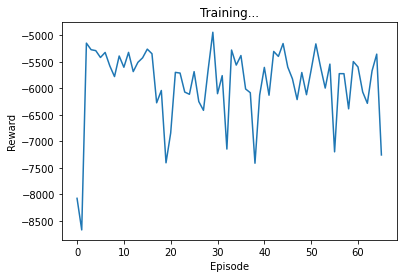

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -57.06540317257202
current_state2 [9.986413043478262, 6.439473134016308, 16.633482809509953, 22.006034185567504, 0, 1, 0, 1, 0, 0]
1
reward -67.68454661413985
current_state2 [8.559782608695654, 9.65920970102446, 18.883227106601154, 28.582327197818575, 0, 1, 0, 0, 1, 0]
1
reward -66.38454730103005
current_state2 [8.559782608695654, 12.878946268032616, 17.146878139200584, 25.798940285101196, 0, 1, 0, 0, 1, 0]
1
reward -67.88857687821617
current_state2 [9.986413043478262, 10.554471812344536, 16.648024518656857, 28.69966750373652, 0, 1, 0, 0, 1, 0]
1
reward -63.54007278171322
current_state2 [9.986413043478262, 9.65920970102446, 14.530629286060393, 27.363820751150104, 0, 1, 0, 0, 1, 0]
1
reward -63.08530659077066
current_state2 [8.559782608695654, 12.878946268032616, 12.05762063223158, 27.588957081810804, 0, 1, 0, 0, 1, 0]
1
reward -64.61493131858464
current_state2 [9.986413043478262, 13.68607829386905, 10.87039810846671, 28.072041872770626, 0, 0, 1, 0, 1, 0]
1
reward -68.75108116026

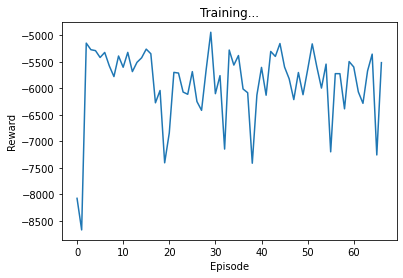

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -30.74788272804807
current_state2 [8.559782608695654, 12.878946268032616, 7.309153851319798, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -26.10

reward -79.09056295098341
current_state2 [22.826086956521742, 3.219736567008154, 21.648834984705772, 29.395904442747735, 0, 1, 0, 0, 1, 0]
1
reward -83.25679736365335
current_state2 [24.25271739130435, 3.219736567008154, 21.26901683321978, 32.51532657212106, 0, 1, 0, 0, 1, 0]
1
reward -76.30627739602265
current_state2 [24.25271739130435, 0.0, 19.43645610483899, 30.617103899879314, 0, 1, 0, 0, 1, 0]
1
reward -77.6509461366356
current_state2 [27.105978260869573, 3.219736567008154, 16.42552845239979, 28.899702856358072, 0, 1, 0, 0, 1, 0]
1
reward -83.36778675197294
current_state2 [28.532608695652183, 9.65920970102446, 12.325102809921193, 30.850865545375115, 0, 1, 0, 0, 1, 0]
1
reward -84.8510329715944
current_state2 [28.96102273615584, 15.399033044301877, 12.35327940957619, 26.137697781560508, 0, 1, 0, 0, 1, 0]
1
reward -88.39884991058362
current_state2 [28.532608695652183, 16.09868283504077, 13.122282180952599, 28.64527619893808, 0, 0, 1, 0, 1, 0]
1
reward -90.47430513191077
current_stat

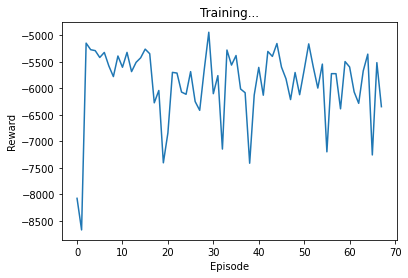

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

current_state2 [28.532608695652183, 6.796600396370998, 25.412217859357565, 26.11487225184555, 0, 1, 0, 0, 0, 1]
1
reward -97.11268356694102
current_state2 [31.2629668209022, 9.65920970102446, 29.499544212412026, 24.69096283260232, 0, 1, 0, 0, 1, 0]
1
reward -93.15055743518027
current_state2 [30.54978824863061, 6.439473134016308, 29.61454877642238, 24.546747276110978, 0, 1, 0, 0, 1, 0]
1
reward -80.58426226319065
current_state2 [29.959239130434796, 0.0, 27.0590688662746, 21.565954266481256, 0, 1, 0, 0, 1, 0]
1
reward -80.59240653606899
current_state2 [31.3858695652174, 3.219736567008154, 20.16124442556329, 23.825555978280146, 0, 1, 0, 0, 1, 0]
5
reward -88.25997106666722
current_state2 [34.23913043478262, 9.65920970102446, 21.289089895376225, 21.072541035483916, 0, 1, 0, 1, 0, 0]
1
reward -99.94139327803744
current_state2 [37.09239130434784, 16.09868283504077, 20.537175735904892, 24.213143402743942, 0, 0, 1, 0, 1, 0]
1
reward -102.33370098875841
current_state2 [37.09239130434784, 14.914

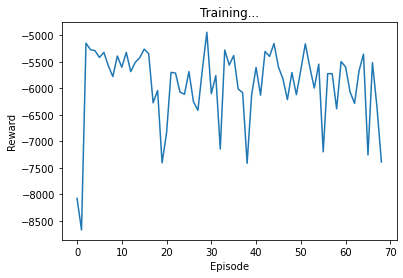

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -73.39237468814504
current_state2 [17.1195652173913, 16.35272244111858, 20.52441780676944, 17.395669222865717, 0, 1, 0, 1, 0, 0]
5
reward -71.68061047538772
current_state2 [17.1195652173913, 16.09868283504077, 19.832100301613092, 16.630262121342554, 0, 1, 0, 1, 0, 0]
5
reward -70.30463392726165
current_state2 [17.1195652173913, 16.09868283504077, 23.77742721887794, 11.308958655951637, 0, 1, 0, 1, 0, 0]
1
reward -73.0449751825957
current_state2 [17.1195652173913, 14.467360822535666, 24.950932963183117, 14.507116179485616, 0, 1, 0, 0, 1, 0]
1
reward -67.53774886284786
current_state2 [15.833394285959123, 12.878946268032616, 23.442968108416725, 13.38244020043941, 0, 1, 0, 0, 1, 0]
5
reward -70.45836415412275
current_state2 [17.1195652173913, 12.378589868291524, 25.870288031160065, 13.089921037279856, 0, 1, 0, 1, 0, 0]
1
reward -71.98314714106455
current_state2 [17.1195652173913, 9.65920970102446, 27.794741554299776, 15.409630668349015, 0, 0, 1, 0, 1, 0]
5
reward -65.33088120044127
c

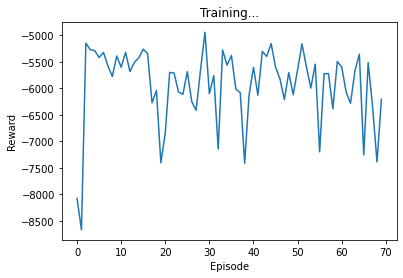

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

current_state2 [32.812500000000014, 13.062552273046323, 15.189237685443302, 27.24840820348622, 0, 1, 0, 0, 1, 0]
1
reward -95.49752291776966
current_state2 [32.812500000000014, 19.31841940204892, 15.513107190213425, 25.853496325507304, 0, 1, 0, 0, 1, 0]
5
reward -97.02793349564605
current_state2 [34.23913043478262, 19.31841940204892, 17.667767028817856, 23.802616629996646, 0, 1, 0, 1, 0, 0]
1
reward -95.6591497336129
current_state2 [34.23913043478262, 16.09868283504077, 20.917176588451753, 22.404159875337772, 0, 1, 0, 0, 1, 0]
1
reward -92.2685830237248
current_state2 [34.23913043478262, 16.09868283504077, 17.60873104072544, 22.32203871317597, 0, 1, 0, 0, 1, 0]
1
reward -87.70784820157039
current_state2 [34.23913043478262, 12.878946268032616, 15.56468198209895, 23.025089516656198, 0, 1, 0, 0, 1, 0]
1
reward -88.76740387085005
current_state2 [34.23913043478262, 11.662587645352266, 13.41970763318717, 27.445978157527993, 0, 0, 1, 0, 1, 0]
5
reward -86.8617781564648
current_state2 [34.2391

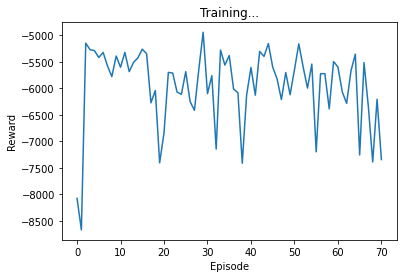

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -25.812808006843245
current_state2 [7.133152173913045, 9.65920970102446, 7.02044613190574, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -23.95591

reward -106.04505121095767
current_state2 [29.959239130434796, 20.53556761564925, 17.823254942539712, 35.7269895223339, 0, 1, 0, 1, 0, 0]
5
reward -103.04403888669009
current_state2 [29.959239130434796, 19.049928861395635, 19.422592220940086, 32.612278673919576, 0, 1, 0, 1, 0, 0]
1
reward -93.96839818161082
current_state2 [29.959239130434796, 12.878946268032616, 18.83080723868514, 30.29940554445827, 0, 1, 0, 0, 1, 0]
1
reward -88.85072606492716
current_state2 [29.184918812124174, 12.878946268032616, 15.940658499219952, 28.84620248555042, 0, 1, 0, 0, 1, 0]
1
reward -89.09659928859185
current_state2 [28.532608695652183, 11.993044085244179, 17.584645262965243, 28.986301244730242, 0, 1, 0, 0, 1, 0]
1
reward -89.60080929183732
current_state2 [28.532608695652183, 12.291502851594709, 13.919253481977705, 32.85744426261272, 0, 0, 1, 0, 1, 0]
5
reward -89.6987335669989
current_state2 [28.532608695652183, 10.762255981265726, 14.954137962718228, 33.449730927362765, 0, 0, 1, 1, 0, 0]
5
reward -98.5

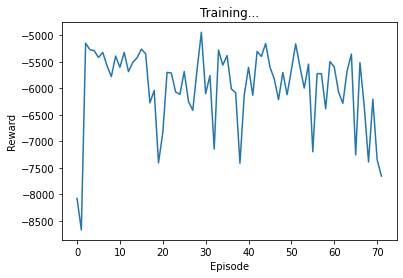

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -109.17733500016853
current_state2 [39.94565217391306, 16.09868283504077, 24.79773225561241, 26.335267735602283, 0, 1, 0, 1, 0, 0]
1
reward -108.98776746602968
current_state2 [39.94565217391306, 16.09868283504077, 24.882408449042615, 26.061024008033225, 0, 1, 0, 0, 1, 0]
1
reward -108.82372955774323
current_state2 [39.94565217391306, 16.09868283504077, 23.397500668513146, 27.38189388027627, 0, 1, 0, 0, 1, 0]
5
reward -105.02383248272487
current_state2 [39.94565217391306, 13.074827749774812, 22.195083797208028, 27.808268761828973, 0, 1, 0, 1, 0, 0]
1
reward -102.79290007566394
current_state2 [39.94565217391306, 13.907192331187279, 21.78149988159913, 25.15855568896447, 0, 1, 0, 0, 1, 0]
5
reward -117.98558865828238
current_state2 [39.94565217391306, 15.437771736485095, 27.943392326054187, 32.65877242183003, 0, 0, 1, 1, 0, 0]
1
reward -112.42054736726286
current_state2 [38.85828056024859, 12.878946268032616, 25.727346549000046, 32.955973989981594, 0, 0, 1, 0, 1, 0]
1
reward -113.88

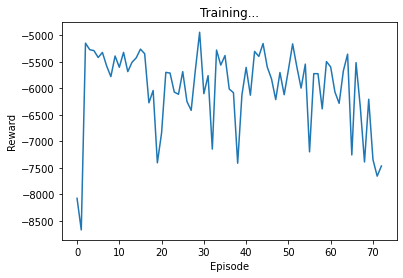

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -52.083994426325205
current_state2 [12.839673913043478, 10.756587925549393, 12.962313463010105, 13.525419124722227, 0, 1, 0, 0, 1, 0]
1
reward -60.61640639769149
current_state2 [12.839673913043478, 16.09868283504077, 13.733639726991822, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -60.251398011634365
current_state2 [14.266304347826086, 18.181521084529756, 13.531842800764826, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -59.7759094734522
current_state2 [14.266304347826086, 18.806348300055337, 12.431527047057081, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -58.546562232393626
current_state2 [14.266304347826086, 16.636569344149702, 12.726963517976753, 12.916725022441085, 0, 1, 0, 0, 1, 0]
1
reward -57.788676359659966
current_state2 [14.266304347826086, 15.444741221524652, 13.201155894379333, 12.876474895929894, 0, 1, 0, 0, 1, 0]
1
reward -54.73235462868142
current_state2 [14.266304347826086, 12.59560459560719, 10.932444027851687, 14.938001657396457, 0, 0, 1, 0, 1, 0]
1
reward

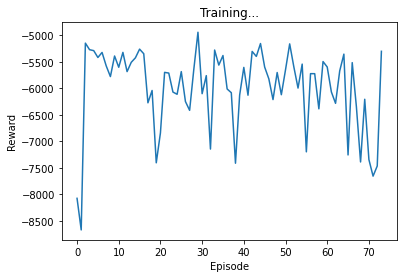

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -20.086547496934692
current_state2 [4.279891304347826, 5.356676079486579, 8.449980113100285, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -22.36779704782719
current_state2 [5.95513138901473, 6.439473134016308, 7.973192524796152, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -24.941349154080953
current_state2 [8.559782608695654, 6.439473134016308, 7.942093411368989, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -21.61022

reward -66.50843190360662
current_state2 [21.399456521739133, 12.878946268032616, 12.583659349101378, 17.646369764733493, 0, 1, 0, 0, 1, 0]
1
reward -58.24712637989813
current_state2 [21.399456521739133, 9.65920970102446, 9.244050234519117, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -59.39401709269034
current_state2 [21.399456521739133, 9.65920970102446, 13.865233631549538, 12.470117238377215, 0, 1, 0, 0, 1, 0]
1
reward -57.193369479418095
current_state2 [21.399456521739133, 7.289468780302707, 12.371586167074463, 14.132858010301797, 0, 1, 0, 0, 1, 0]
5
reward -57.047353818186124
current_state2 [21.14694508667079, 7.873689217336112, 13.161532664879829, 12.86518684929939, 0, 1, 0, 1, 0, 0]
1
reward -58.38764335478344
current_state2 [19.972826086956523, 12.878946268032616, 12.159257897714179, 11.376613102080126, 0, 1, 0, 0, 1, 0]
1
reward -67.43478482388804
current_state2 [21.399456521739133, 16.09868283504077, 14.554205266668731, 13.38244020043941, 0, 0, 1, 0, 1, 0]
5
reward -63.40608

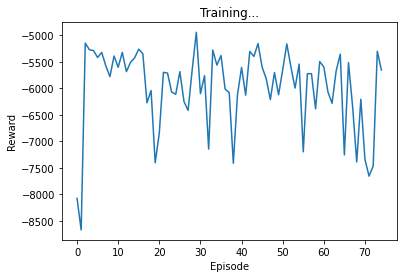

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -19.246584399405243
current_state2 [4.279891304347826, 5.356676079486579, 7.610017015570836, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.656705650479985
current_state2 [6.213453584165474, 6.439473134016308, 7.003778932298202, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -25.812808006843245
current_state2 [7.133152173913045, 9.65920970102446, 7.02044613190574, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -23.95591

reward -54.311686659341014
current_state2 [12.839673913043478, 9.65920970102446, 14.267526630494217, 15.54527641477886, 0, 1, 0, 1, 0, 0]
1
reward -57.165926210763025
current_state2 [12.839673913043478, 9.65920970102446, 18.094728486970084, 14.572314109725008, 0, 1, 0, 0, 1, 0]
5
reward -49.52947223927711
current_state2 [11.413043478260871, 9.65920970102446, 14.323544160253885, 12.133674899737896, 0, 1, 0, 1, 0, 0]
1
reward -62.074345737669034
current_state2 [11.413043478260871, 14.646449762986775, 17.66399574265996, 16.35085675376143, 0, 1, 0, 0, 1, 0]
1
reward -63.793728628979906
current_state2 [12.839673913043478, 12.878946268032616, 18.119334049071412, 17.955774398832407, 0, 1, 0, 0, 1, 0]
1
reward -54.01345837229192
current_state2 [12.839673913043478, 12.878946268032616, 14.308715445738189, 11.986122745477637, 0, 1, 0, 0, 1, 0]
1
reward -56.008757959532105
current_state2 [12.839673913043478, 10.854596693661286, 13.357438849441003, 16.957048503386343, 0, 0, 1, 0, 1, 0]
1
reward -58

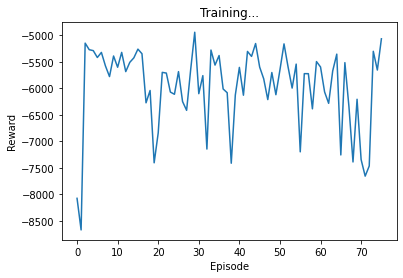

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -18.375357240525183
current_state2 [4.279891304347826, 3.219736567008154, 8.875729369169205, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -22.09030210776301
current_state2 [5.825672409666793, 6.439473134016308, 7.825156564079908, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -24.685445225727378
current_state2 [8.559782608695654, 6.439473134016308, 7.686189483015413, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -21.6102

reward -64.41030408985108
current_state2 [21.399456521739133, 12.878946268032616, 12.22995269721686, 15.901948602862484, 0, 1, 0, 0, 1, 0]
1
reward -66.03476298707714
current_state2 [21.399456521739133, 12.878946268032616, 15.6961675537038, 14.060192643601598, 0, 1, 0, 0, 1, 0]
1
reward -51.41930489220467
current_state2 [21.399456521739133, 6.439473134016308, 12.072397815778103, 9.50797742067113, 0, 1, 0, 0, 1, 0]
1
reward -57.54423174850315
current_state2 [21.399456521739133, 9.65920970102446, 11.969479373239032, 12.51608615250053, 0, 1, 0, 0, 1, 0]
1
reward -60.99435763129578
current_state2 [22.826086956521742, 9.65920970102446, 11.379471199066018, 15.12958977468356, 0, 1, 0, 0, 1, 0]
1
reward -65.4284198635146
current_state2 [22.826086956521742, 16.09868283504077, 8.953126540968798, 15.550523530983298, 0, 1, 0, 0, 1, 0]
3
reward -61.652600492079486
current_state2 [22.826086956521742, 12.555803755498765, 15.336576858926232, 8.934132921132742, 0, 0, 1, 0, 0, 1]
3
reward -61.1959160767

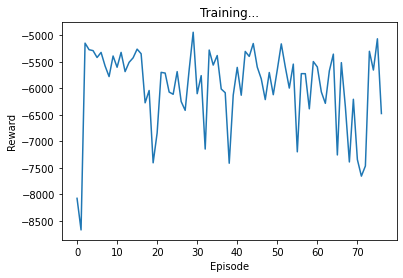

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -55.87582427235733
current_state2 [14.266304347826086, 12.878946268032616, 13.205154531776403, 13.525419124722227, 0, 1, 0, 0, 1, 0]
1
reward -56.38915171705175
current_state2 [14.266304347826086, 12.322696667791684, 11.662422005635879, 16.13772869579811, 0, 1, 0, 0, 1, 0]
1
reward -47.38007091598588
current_state2 [14.266304347826086, 9.65920970102446, 10.363531647060217, 11.091025220075124, 0, 1, 0, 0, 1, 0]
1
reward -52.98772826418682
current_state2 [14.266304347826086, 12.878946268032616, 9.689876582980583, 14.152601065347541, 0, 1, 0, 0, 1, 0]
1
reward -55.528384417520876
current_state2 [15.476377139883798, 12.878946268032616, 12.901331231090763, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -51.62264099135285
current_state2 [14.266304347826086, 12.878946268032616, 11.367829927932522, 11.109560447561636, 0, 1, 0, 0, 1, 0]
5
reward -55.116157437826395
current_state2 [14.266304347826086, 14.809710005056742, 10.657702884504157, 13.38244020043941, 0, 0, 1, 1, 0, 0]
5
reward -5

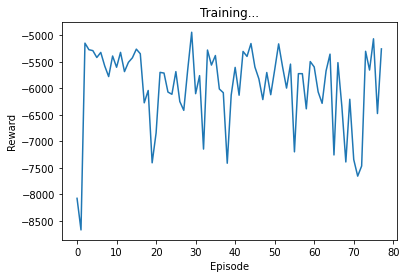

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -28.6

reward -74.18855456828014
current_state2 [19.972826086956523, 9.65920970102446, 23.907160211224912, 18.64935856907425, 0, 1, 0, 0, 1, 0]
5
reward -82.80663651870842
current_state2 [22.826086956521742, 12.878946268032616, 28.02658871360882, 17.075014580545243, 0, 1, 0, 1, 0, 0]
5
reward -74.26179811746266
current_state2 [21.554148993846038, 9.65920970102446, 28.919688568361273, 12.12875085423088, 0, 1, 0, 1, 0, 0]
5
reward -80.92677426292119
current_state2 [21.399456521739133, 12.878946268032616, 28.11932164331969, 16.52904982982975, 0, 1, 0, 1, 0, 0]
5
reward -81.49166487299803
current_state2 [21.399456521739133, 12.878946268032616, 27.62196877554691, 17.591293307679376, 0, 1, 0, 1, 0, 0]
5
reward -76.3268328687639
current_state2 [21.399456521739133, 12.878946268032616, 26.347580993318648, 13.700849085673513, 0, 1, 0, 1, 0, 0]
5
reward -88.46988820812876
current_state2 [21.399456521739133, 16.09868283504077, 30.45614202994212, 18.515606821406745, 0, 0, 1, 1, 0, 0]
1
reward -87.79944811

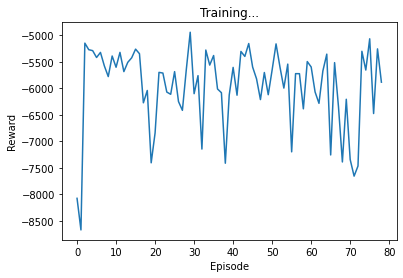

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -64.14824867237286
current_state2 [11.413043478260871, 7.432850207753703, 15.859322818055443, 27.443032168302846, 0, 1, 0, 1, 0, 0]
1
reward -67.68183084064843
current_state2 [11.413043478260871, 8.569389652362672, 18.253419552496894, 27.445978157527993, 0, 1, 0, 0, 1, 0]
1
reward -67.74607391670902
current_state2 [11.413043478260871, 9.674249252208648, 15.813167696225609, 28.845613490013886, 0, 1, 0, 0, 1, 0]
1
reward -69.47199129789048
current_state2 [11.413043478260871, 14.412884693566037, 12.854511801460944, 28.791551324602626, 0, 1, 0, 0, 1, 0]
1
reward -66.93380055855155
current_state2 [11.413043478260871, 14.660851966910357, 11.205873215161947, 27.654031898218378, 0, 1, 0, 0, 1, 0]
1
reward -63.731693961655026
current_state2 [11.413043478260871, 12.878946268032616, 12.412716855726732, 25.0269873596348, 0, 1, 0, 0, 1, 0]
5
reward -57.74391566728157
current_state2 [11.413043478260871, 6.439473134016308, 12.266088142807336, 25.625310912197055, 0, 0, 1, 1, 0, 0]
1
reward -60.

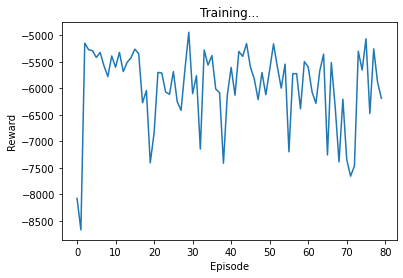

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -11.490629430231749
current_state2 [1.4266304347826089, 0.0, 8.06399899544914, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -12.908653281026606
current_state2 [2.8532608695652177, 0.0, 8.055392411461389, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -15.402378313245318
current_state2 [4.279891304347826, 0.0, 9.122487008897492, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -19.105297318189066
current_state2 [5.7065217391304355, 3.219736567008154, 8.17903901205048, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -21.583020325825114
current_state2 [8.559782608695654, 3.219736567008154, 7.803501150121306, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.903102452089247
cu

reward -85.87571472920989
current_state2 [21.399456521739133, 16.09868283504077, 16.127997990898276, 30.249577381531708, 0, 1, 0, 0, 0, 1]
1
reward -84.52454120537874
current_state2 [21.399456521739133, 19.31841940204892, 14.214141368956396, 27.592523912634288, 0, 1, 0, 0, 1, 0]
3
reward -85.12313406606935
current_state2 [21.399456521739133, 19.31841940204892, 16.384591497735144, 26.020666644546157, 0, 1, 0, 0, 0, 1]
1
reward -86.22234661024123
current_state2 [21.399456521739133, 16.09868283504077, 22.72627220764943, 23.997935045811904, 0, 1, 0, 0, 1, 0]
1
reward -79.87597203167707
current_state2 [21.161365363373235, 12.878946268032616, 18.845920018065037, 24.989740382206183, 0, 1, 0, 0, 1, 0]
3
reward -71.68018010080098
current_state2 [19.972826086956523, 6.439473134016308, 19.461665567249597, 23.80621531257856, 0, 1, 0, 0, 0, 1]
3
reward -77.4836291707034
current_state2 [19.972826086956523, 6.439473134016308, 22.969550686275554, 26.10177926345501, 0, 0, 1, 0, 0, 1]
3
reward -80.07864

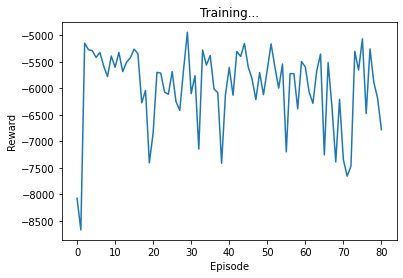

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -21.255227432433223
current_state2 [5.742048812853463, 6.439473134016308, 7.073705485563449, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.510570942619076
current_state2 [8.559782608695654, 12.878946268032616, 7.071842065890805, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -24.8

reward -57.15264197433817
current_state2 [17.1195652173913, 9.65920970102446, 16.956989585244038, 11.416877470678367, 0, 1, 0, 1, 0, 0]
1
reward -53.103233665434686
current_state2 [17.1195652173913, 6.439473134016308, 15.272465535513382, 12.271729778513697, 0, 1, 0, 0, 1, 0]
5
reward -50.31314415904333
current_state2 [17.1195652173913, 8.710029796689932, 14.197412706429239, 8.286136438532859, 0, 1, 0, 1, 0, 0]
5
reward -62.84129137540255
current_state2 [18.54619565217391, 13.46357327885959, 17.56740820736211, 11.264114237006938, 0, 1, 0, 1, 0, 0]
1
reward -66.2145611468674
current_state2 [18.330435314578615, 13.387593748278793, 18.60028088365483, 13.896251200355152, 0, 1, 0, 0, 1, 0]
1
reward -61.8015295297082
current_state2 [17.1195652173913, 12.878946268032616, 14.969318543594564, 14.83369950068971, 0, 1, 0, 0, 1, 0]
5
reward -66.95028235129507
current_state2 [17.1195652173913, 12.878946268032616, 17.621785499201838, 17.329985366669327, 0, 0, 1, 1, 0, 0]
1
reward -66.86031796267287
c

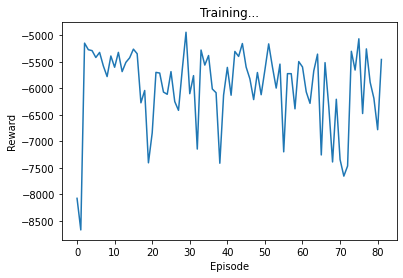

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -53.80797460048359
current_state2 [11.413043478260871, 12.878946268032616, 12.825264277783212, 14.69072057640689, 0, 1, 0, 0, 1, 0]
1
reward -60.045644718784686
current_state2 [12.839673913043478, 16.09868283504077, 10.457929401626194, 18.64935856907425, 0, 1, 0, 0, 1, 0]
5
reward -61.98154290853522
current_state2 [12.839673913043478, 12.878946268032616, 14.216486726938092, 20.046436000521037, 0, 1, 0, 1, 0, 0]
5
reward -63.822586570104036
current_state2 [12.839673913043478, 12.878946268032616, 14.89263809777769, 21.211328291250258, 0, 1, 0, 1, 0, 0]
1
reward -60.04492435785319
current_state2 [12.839673913043478, 14.129196917179367, 13.680384304764626, 17.395669222865717, 0, 1, 0, 0, 1, 0]
5
reward -51.46098355335078
current_state2 [11.413043478260871, 12.878946268032616, 13.514892163612917, 11.654101643444372, 0, 1, 0, 1, 0, 0]
1
reward -60.60979070560981
current_state2 [11.413043478260871, 15.584097550015844, 16.96377321264796, 14.648876464685133, 0, 0, 1, 0, 1, 0]
1
reward -5

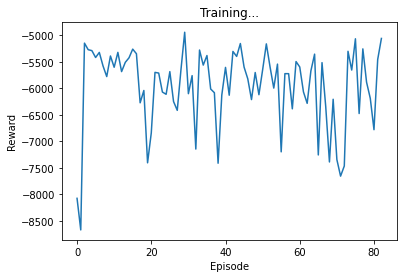

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.

reward -75.31519161302106
current_state2 [25.67934782608696, 19.31841940204892, 16.115470500674682, 12.201953884210484, 0, 1, 0, 0, 1, 0]
1
reward -75.75287853848815
current_state2 [25.67934782608696, 19.176950547562328, 16.003904386063184, 12.892675778775674, 0, 1, 0, 0, 1, 0]
1
reward -62.51790088242224
current_state2 [25.67934782608696, 14.142206214956746, 11.546492920447946, 9.149853920930587, 0, 1, 0, 0, 1, 0]
1
reward -63.84032163247962
current_state2 [25.67934782608696, 12.878946268032616, 11.010297759846356, 12.271729778513697, 0, 1, 0, 0, 1, 0]
1
reward -67.59676129324463
current_state2 [24.664874373676334, 14.207845986890167, 13.690505212374715, 13.033535720303403, 0, 1, 0, 0, 1, 0]
1
reward -64.60873768565907
current_state2 [24.25271739130435, 16.09868283504077, 11.816431955842193, 10.440905503471763, 0, 1, 0, 0, 1, 0]
1
reward -69.86939870850648
current_state2 [24.25271739130435, 19.116914122196434, 11.163181663502526, 13.336585531503163, 0, 0, 1, 0, 1, 0]
1
reward -60.6170

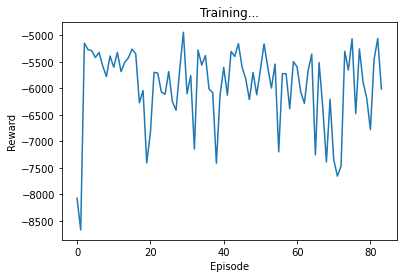

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -65.6916427943874
current_state2 [18.54619565217391, 3.219736567008154, 19.81364610082687, 22.11206447437847, 0, 1, 0, 0, 1, 0]
1
reward -65.07820598610537
current_state2 [18.54619565217391, 3.219736567008154, 17.81456022100063, 23.497713545922682, 0, 1, 0, 0, 1, 0]
1
reward -65.10887765102481
current_state2 [19.972826086956523, 6.439473134016308, 13.299120786812171, 23.397457643239807, 0, 1, 0, 0, 1, 0]
5
reward -72.71767175408402
current_state2 [19.972826086956523, 10.814545318560342, 18.11875015024653, 21.811550198320628, 0, 1, 0, 1, 0, 0]
5
reward -70.28285063349695
current_state2 [19.972826086956523, 11.942510821713416, 18.425498131542888, 17.942015593284122, 0, 1, 0, 1, 0, 0]
1
reward -73.63986189149375
current_state2 [19.972826086956523, 13.251321613011976, 16.09367547834929, 22.32203871317597, 0, 1, 0, 0, 1, 0]
1
reward -75.51085631452314
current_state2 [19.972826086956523, 16.09868283504077, 17.712778889299845, 19.726568503226005, 0, 0, 1, 0, 1, 0]
1
reward -77.29078713

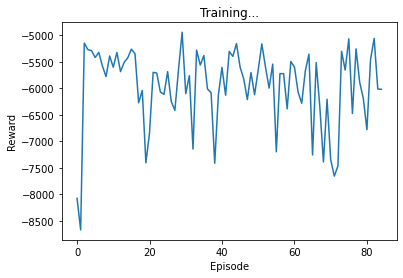

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -30.16497769392853
current_state2 [8.559782608695654, 12.878946268032616, 6.726248817200261, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -25.30

reward -65.74913536084159
current_state2 [11.413043478260871, 16.09868283504077, 13.83403556287984, 22.403373484660108, 0, 1, 0, 0, 1, 0]
1
reward -63.74827221536664
current_state2 [11.413043478260871, 16.09868283504077, 13.025217610814746, 21.211328291250258, 0, 1, 0, 0, 1, 0]
3
reward -60.06261328863113
current_state2 [11.413043478260871, 9.65920970102446, 17.373270042628647, 19.617090066717143, 0, 1, 0, 0, 0, 1]
5
reward -61.433172492424305
current_state2 [11.413043478260871, 9.10722582875916, 16.622882138346917, 22.290021047057355, 0, 1, 0, 1, 0, 0]
5
reward -60.274033246646894
current_state2 [11.413043478260871, 6.439473134016308, 20.07094273298232, 20.350573901387396, 0, 1, 0, 1, 0, 0]
5
reward -57.58650514508861
current_state2 [12.839673913043478, 3.683280393870614, 20.862363864954364, 18.201186973220157, 0, 1, 0, 1, 0, 0]
1
reward -53.321751399692616
current_state2 [12.839673913043478, 3.219736567008154, 18.894891524090006, 16.367449395550974, 0, 0, 1, 0, 1, 0]
3
reward -63.886

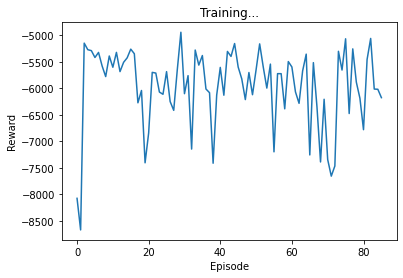

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.55

reward -49.64867717079649
current_state2 [14.266304347826086, 9.65920970102446, 10.347266332608735, 13.375896789337212, 0, 1, 0, 0, 1, 0]
1
reward -53.26418029101036
current_state2 [14.266304347826086, 8.80401068913137, 12.249455331437485, 15.94440992261542, 0, 1, 0, 0, 1, 0]
5
reward -51.028706738812176
current_state2 [14.266304347826086, 9.65920970102446, 13.719535452423987, 11.38365723753765, 0, 1, 0, 1, 0, 0]
5
reward -55.35096419558342
current_state2 [15.692934782608695, 9.65920970102446, 13.604233544153754, 14.394586167796513, 0, 1, 0, 1, 0, 0]
1
reward -46.844938102377704
current_state2 [15.25548279665532, 6.439473134016308, 12.09291354895972, 11.057068622746359, 0, 1, 0, 0, 1, 0]
1
reward -43.98886029121375
current_state2 [14.266304347826086, 0.0, 14.763093875645037, 12.959462067742622, 0, 1, 0, 0, 1, 0]
1
reward -44.77967760349975
current_state2 [15.692934782608695, 3.219736567008154, 10.451233026647165, 13.415773227235732, 0, 0, 1, 0, 1, 0]
5
reward -56.24235653299832
current

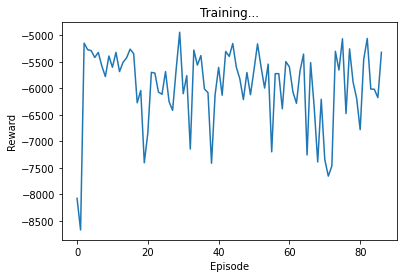

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -62.052140684207316
current_state2 [19.972826086956523, 12.878946268032616, 8.30284142681837, 18.897526902399807, 0, 1, 0, 0, 1, 0]
1
reward -54.372119994355145
current_state2 [19.972826086956523, 6.569414259229032, 10.850671841187042, 14.97920780698255, 0, 1, 0, 0, 1, 0]
1
reward -52.76287178737333
current_state2 [19.972826086956523, 6.439473134016308, 12.424639150170615, 11.925933416229881, 0, 1, 0, 0, 1, 0]
1
reward -61.337750138947456
current_state2 [20.114148826182202, 12.878946268032616, 9.700611853329587, 16.644043191403053, 0, 1, 0, 0, 1, 0]
1
reward -63.0876050521633
current_state2 [21.399456521739133, 16.09868283504077, 12.805478023754937, 10.783987671628461, 0, 1, 0, 0, 1, 0]
5
reward -62.98334211143756
current_state2 [19.972826086956523, 15.608891393097107, 14.295136431316148, 11.10648820006778, 0, 1, 0, 1, 0, 0]
1
reward -62.44139752854561
current_state2 [19.972826086956523, 12.878946268032616, 11.723655611053047, 15.865969562503423, 0, 0, 1, 0, 1, 0]
1
reward -59.4

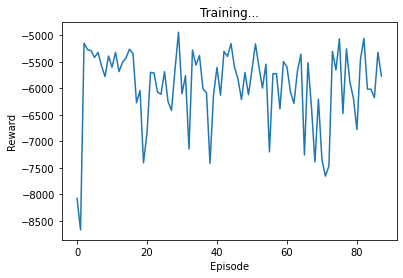

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -60.70177242566052
current_state2 [19.972826086956523, 9.65920970102446, 14.140352828866693, 14.929383808812842, 0, 1, 0, 0, 1, 0]
1
reward -54.936047625667875
current_state2 [19.972826086956523, 6.439473134016308, 11.62470025656049, 14.899048148134552, 0, 1, 0, 0, 1, 0]
1
reward -59.77207932727935
current_state2 [19.972826086956523, 12.878946268032616, 12.648577193776521, 12.271729778513697, 0, 1, 0, 0, 1, 0]
5
reward -67.17840339796528
current_state2 [19.972826086956523, 16.09868283504077, 14.273194975278283, 14.83369950068971, 0, 1, 0, 1, 0, 0]
5
reward -63.518226268340094
current_state2 [19.972826086956523, 16.09868283504077, 13.757700464188371, 11.689016882154425, 0, 1, 0, 1, 0, 0]
5
reward -60.39955186574652
current_state2 [19.972826086956523, 12.878946268032616, 13.276049732243685, 12.271729778513697, 0, 1, 0, 1, 0, 0]
5
reward -68.88681885343648
current_state2 [19.972826086956523, 12.878946268032616, 18.090636575831923, 15.94440992261542, 0, 0, 1, 1, 0, 0]
5
reward -62.6

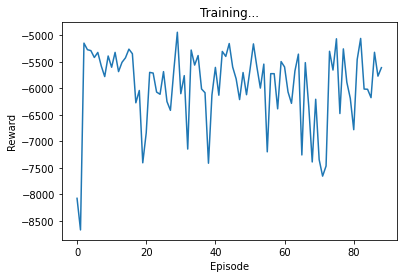

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -62.87800680844431
current_state2 [15.692934782608695, 9.70323391288205, 14.067717861352477, 21.414120251601087, 0, 1, 0, 0, 1, 0]
5
reward -68.4367588711495
current_state2 [15.692934782608695, 9.65920970102446, 18.877408162221844, 22.207206225294502, 0, 1, 0, 1, 0, 0]
5
reward -65.57658054483154
current_state2 [15.692934782608695, 9.65920970102446, 19.443470194515157, 18.780965866683236, 0, 1, 0, 1, 0, 0]
5
reward -69.37272197219829
current_state2 [17.1195652173913, 9.65920970102446, 18.913947085121134, 21.679999968661388, 0, 1, 0, 1, 0, 0]
5
reward -60.97931137214712
current_state2 [17.1195652173913, 6.439473134016308, 16.817591729345917, 18.602681291393598, 0, 1, 0, 1, 0, 0]
5
reward -74.9786812318041
current_state2 [17.1195652173913, 12.878946268032616, 21.101206296323596, 21.87896345005659, 0, 1, 0, 1, 0, 0]
1
reward -74.47301889509876
current_state2 [18.54619565217391, 16.09868283504077, 19.343293544526897, 18.484846863357173, 0, 0, 1, 0, 1, 0]
1
reward -71.11511582849025


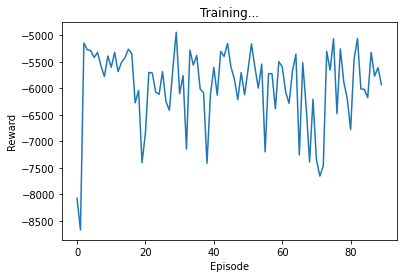

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -12.033873761583141
current_state2 [2.8532608695652177, 0.0, 7.180612892017923, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.77274308962486
current_state2 [5.742048812853463, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.55

reward -71.64788028117809
current_state2 [18.54619565217391, 19.25891675001735, 11.146763270764028, 20.696004608222804, 0, 1, 0, 0, 0, 1]
3
reward -75.22759191657902
current_state2 [18.54619565217391, 16.09868283504077, 18.19245202831644, 20.390261401047894, 0, 1, 0, 0, 0, 1]
5
reward -69.58538305852974
current_state2 [18.54619565217391, 12.878946268032616, 18.057039177140787, 18.10320196118243, 0, 1, 0, 1, 0, 0]
5
reward -61.460918843452774
current_state2 [18.54619565217391, 6.439473134016308, 18.107792126331574, 16.367457930930986, 0, 1, 0, 1, 0, 0]
5
reward -55.16383084870551
current_state2 [18.10738188845931, 0.0, 22.358728778803467, 12.697720181442724, 0, 1, 0, 1, 0, 0]
1
reward -56.77847161509304
current_state2 [18.028592668789457, 3.219736567008154, 21.40420747836369, 12.125934900931739, 0, 1, 0, 0, 1, 0]
5
reward -64.34134496872025
current_state2 [19.972826086956523, 6.624439047511686, 19.799669911636613, 15.94440992261542, 0, 0, 1, 1, 0, 0]
5
reward -75.07506915824045
current_

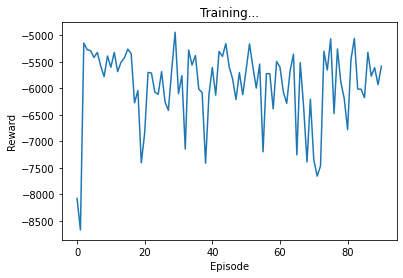

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -22.357814871613634
current_state2 [6.549322703700532, 6.439473134016308, 7.369019033896796, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -30.74788272804807
current_state2 [8.559782608695654, 12.878946268032616, 7.309153851319798, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -26.10

reward -73.48310989892718
current_state2 [18.54619565217391, 15.410999913743106, 11.388216551449661, 26.137697781560508, 0, 1, 0, 0, 1, 0]
1
reward -62.648980934977416
current_state2 [18.54619565217391, 7.058189496150059, 10.615724047918253, 24.428871738735193, 0, 1, 0, 0, 1, 0]
1
reward -64.04657802114389
current_state2 [18.54619565217391, 9.65920970102446, 11.343797991515522, 22.497374676429985, 0, 1, 0, 0, 1, 0]
5
reward -69.27887697671025
current_state2 [18.54619565217391, 12.878946268032616, 14.642406765253462, 21.211328291250258, 0, 1, 0, 1, 0, 0]
1
reward -69.24129964498965
current_state2 [19.972826086956523, 12.878946268032616, 12.067488576824546, 22.32203871317597, 0, 1, 0, 0, 1, 0]
1
reward -64.70273748683634
current_state2 [19.972826086956523, 6.439473134016308, 12.640648209106635, 23.64979005675688, 0, 1, 0, 0, 1, 0]
1
reward -65.25603485563019
current_state2 [19.972826086956523, 6.439473134016308, 13.251661209007025, 23.592074425650335, 0, 0, 1, 0, 1, 0]
1
reward -61.32038

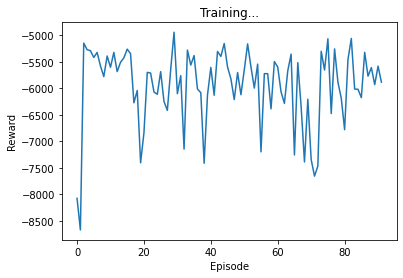

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
3
reward -29.1

reward -68.5783273192796
current_state2 [21.399456521739133, 12.878946268032616, 14.160688184800382, 18.139236344707466, 0, 1, 0, 0, 1, 0]
1
reward -65.73918667673104
current_state2 [21.399456521739133, 12.878946268032616, 13.51637396434388, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -56.839289076148724
current_state2 [19.972826086956523, 9.65920970102446, 15.152053194502429, 10.055200093665311, 0, 1, 0, 0, 1, 0]
1
reward -55.97413276553381
current_state2 [19.972826086956523, 6.456984536814671, 14.161881941323204, 13.38244020043941, 0, 1, 0, 0, 1, 0]
1
reward -61.61258486902971
current_state2 [19.972826086956523, 13.298412745081045, 11.448020097431383, 14.893325939560762, 0, 1, 0, 0, 1, 0]
1
reward -60.69300323031404
current_state2 [21.399456521739133, 16.09868283504077, 11.62808274147927, 9.566781132054869, 0, 1, 0, 0, 1, 0]
1
reward -64.35452119392772
current_state2 [21.399456521739133, 14.180777465508648, 13.44163038628636, 13.332656820393586, 0, 0, 1, 0, 1, 0]
1
reward -62.88130

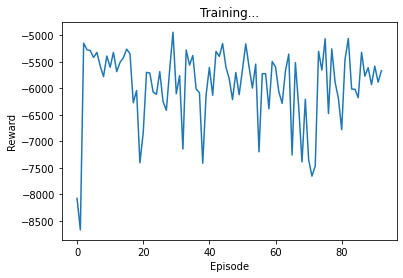

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -21.70651729516435
current_state2 [5.8946060775001845, 6.439473134016308, 7.3724380836478565, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -31.1203255242111
current_state2 [8.559782608695654, 12.878946268032616, 7.68159664748283, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -25.38254

reward -69.30776793333587
current_state2 [18.54619565217391, 9.530613720457378, 13.46384388204357, 25.767114678661013, 0, 1, 0, 1, 0, 0]
5
reward -67.26391217834804
current_state2 [18.54619565217391, 10.778816839024625, 11.379471199066018, 24.559428488083483, 0, 1, 0, 1, 0, 0]
5
reward -67.48526367169244
current_state2 [17.1195652173913, 9.65920970102446, 17.264614626319705, 21.44187412695697, 0, 1, 0, 1, 0, 0]
1
reward -66.3808969383779
current_state2 [18.54619565217391, 9.65920970102446, 13.853452872003562, 22.32203871317597, 0, 1, 0, 0, 1, 0]
1
reward -57.117819869286635
current_state2 [18.54619565217391, 6.439473134016308, 11.683980164823211, 18.44817091827321, 0, 1, 0, 0, 1, 0]
1
reward -65.38654690863417
current_state2 [19.537373249997685, 12.878946268032616, 13.755133223462998, 17.215094167140872, 0, 1, 0, 0, 1, 0]
5
reward -72.30700073061533
current_state2 [19.972826086956523, 14.709742498110911, 16.18620978970953, 19.438222355838356, 0, 0, 1, 1, 0, 0]
1
reward -73.331799199768

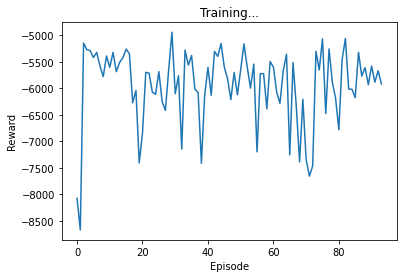

3
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -73.46476624487487
current_state2 [15.692934782608695, 15.341194960138276, 11.416375734937487, 29.014260767190404, 0, 1, 0, 0, 1, 0]
1
reward -73.01544208380061
current_state2 [15.692934782608695, 16.09868283504077, 13.086126684590642, 26.137697781560508, 0, 1, 0, 0, 1, 0]
5
reward -70.47065556693772
current_state2 [14.549346175707745, 16.09868283504077, 12.362124909206548, 25.460501646982653, 0, 1, 0, 1, 0, 0]
1
reward -65.05573588144766
current_state2 [14.266304347826086, 13.889431378575843, 14.604155375056108, 20.295844779989626, 0, 1, 0, 0, 1, 0]
1
reward -65.27378453200606
current_state2 [14.266304347826086, 12.878946268032616, 15.710982381040516, 20.417551535106842, 0, 1, 0, 0, 1, 0]
1
reward -54.91736330470793
current_state2 [14.266304347826086, 9.65920970102446, 10.787243736462107, 18.204605519395283, 0, 1, 0, 0, 1, 0]
1
reward -56.77199560513809
current_state2 [14.266304347826086, 8.158470448385952, 10.369799520681632, 21.97742128824441, 0, 0, 1, 0, 1, 0]
1
reward -62.2

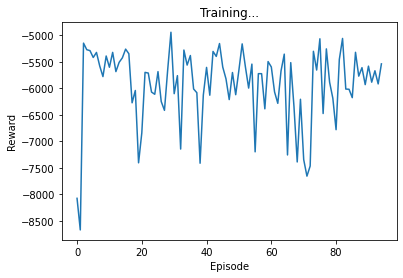

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -30.645028965178902
current_state2 [8.559782608695654, 12.878946268032616, 7.2063000884506305, 0.0, 0, 1, 0, 1, 0, 0]
5
reward -28.

reward -65.91235614809223
current_state2 [11.413043478260871, 12.813627926477716, 14.302027292920243, 25.3836574504334, 0, 1, 0, 1, 0, 0]
1
reward -64.12808312981488
current_state2 [11.413043478260871, 10.881708677795043, 15.895323976358823, 23.938006997400137, 0, 1, 0, 0, 1, 0]
5
reward -63.08088153170793
current_state2 [11.413043478260871, 12.878946268032616, 15.250186167597732, 21.538705617816714, 0, 1, 0, 1, 0, 0]
1
reward -57.72305757157329
current_state2 [11.413043478260871, 10.618977617733881, 14.359685155928736, 19.3313513196498, 0, 1, 0, 0, 1, 0]
5
reward -61.204494044925944
current_state2 [11.413043478260871, 9.65920970102446, 18.721357389610027, 19.410883476030584, 0, 1, 0, 1, 0, 0]
1
reward -63.3474345028322
current_state2 [11.413043478260871, 9.65920970102446, 18.84923237140364, 21.425948952143234, 0, 1, 0, 0, 1, 0]
1
reward -58.134690622199074
current_state2 [11.413043478260871, 6.439473134016308, 17.213824642954453, 21.06834936696744, 0, 0, 1, 0, 1, 0]
1
reward -60.79606

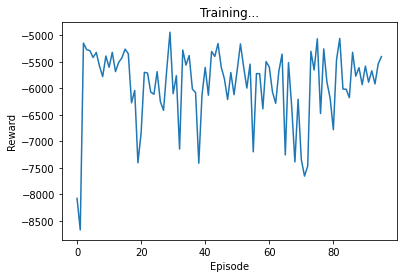

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -59.86690007492177
current_state2 [17.1195652173913, 6.439473134016308, 15.004829932605233, 19.303031790908932, 0, 1, 0, 1, 0, 0]
5
reward -64.49346746358823
current_state2 [18.54619565217391, 9.65920970102446, 14.212808917146374, 20.075253193243483, 0, 1, 0, 1, 0, 0]
5
reward -64.86790038011749
current_state2 [18.54619565217391, 14.206182247128144, 13.737769182352181, 16.377753298463258, 0, 1, 0, 1, 0, 0]
1
reward -66.38467036280511
current_state2 [18.54619565217391, 12.878946268032616, 18.125828941908875, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -64.76174395696626
current_state2 [18.54619565217391, 10.916742945783401, 17.35439543639353, 15.94440992261542, 0, 1, 0, 0, 1, 0]
1
reward -62.37473134256501
current_state2 [18.54619565217391, 12.878946268032616, 14.231419457720607, 14.71816996463788, 0, 1, 0, 0, 1, 0]
1
reward -64.89206937953088
current_state2 [18.54619565217391, 16.09868283504077, 13.088856053839066, 15.15833483847714, 0, 0, 1, 0, 1, 0]
1
reward -61.413226048768

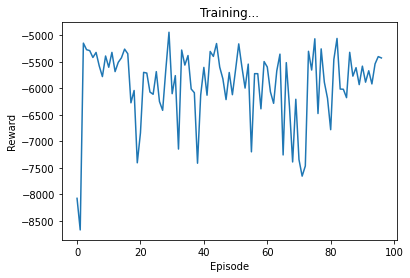

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -10.938050729628936
current_state2 [1.4266304347826089, 0.0, 7.511420294846326, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -17.53167681908573
current_state2 [4.279891304347826, 3.219736567008154, 8.032048947729754, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -20.585655805305237
current_state2 [5.749599335365497, 6.439473134016308, 6.396583335923431, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.6810223137696
current_state2 [8.559782608695654, 12.878946268032616, 7.2422934370413286, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.5030

reward -64.88125845798797
current_state2 [15.692934782608695, 16.09868283504077, 17.59238524073664, 13.497255599601855, 0, 1, 0, 0, 1, 0]
1
reward -60.80420663765725
current_state2 [15.692934782608695, 9.65920970102446, 18.618362653334387, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -53.31022356737357
current_state2 [15.692934782608695, 9.65920970102446, 16.071000709626727, 9.887078374113687, 0, 1, 0, 0, 1, 0]
1
reward -52.582261817880145
current_state2 [15.692934782608695, 12.189291797975674, 12.99027518095809, 9.709760056337686, 0, 1, 0, 0, 1, 0]
1
reward -61.06114193914793
current_state2 [17.1195652173913, 15.34536485314434, 13.25620969817749, 13.340002170434802, 0, 1, 0, 0, 1, 0]
1
reward -52.239857376035175
current_state2 [15.839536571109173, 16.09868283504077, 9.170170272399695, 9.13146769748554, 0, 1, 0, 0, 1, 0]
1
reward -59.057499937172665
current_state2 [15.692934782608695, 12.878946268032616, 12.54534964144925, 15.940269245082106, 0, 0, 1, 0, 1, 0]
1
reward -52.37712345977

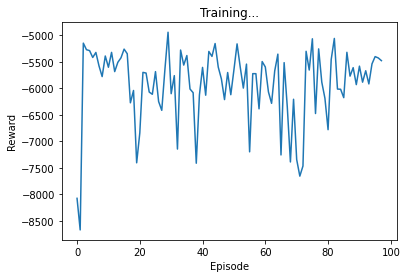

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 1, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.433370182130464
current_state2 [6.402675905359066, 6.439473134016308, 6.591221142755089, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.681280337114863
current_state2 [8.559782608695654, 12.878946268032616, 7.242551460386594, 0.0, 0, 1, 0, 0, 1, 0]
1
reward -28.0

reward -60.257741962984184
current_state2 [11.413043478260871, 16.09868283504077, 14.797089433066668, 15.948926216615876, 0, 1, 0, 0, 1, 0]
1
reward -62.3707227344337
current_state2 [11.413043478260871, 16.09868283504077, 15.194907161711487, 17.664089259420567, 0, 1, 0, 0, 1, 0]
1
reward -60.21945691511597
current_state2 [11.413043478260871, 16.09868283504077, 14.763320679198909, 15.94440992261542, 0, 1, 0, 0, 1, 0]
5
reward -58.260039433466005
current_state2 [11.413043478260871, 12.878946268032616, 13.318691118098272, 18.64935856907425, 0, 1, 0, 1, 0, 0]
1
reward -52.91903425258662
current_state2 [11.413043478260871, 12.878946268032616, 11.793345005603419, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -49.81358828764397
current_state2 [9.986413043478262, 11.372813671394729, 16.25298631277876, 10.201375259992217, 0, 1, 0, 0, 1, 0]
1
reward -48.685107657932264
current_state2 [9.986413043478262, 9.65920970102446, 12.546809027402597, 14.492675886026946, 0, 0, 1, 0, 1, 0]
3
reward -45.7670

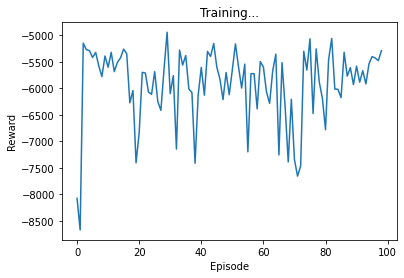

1
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 0, 1, 0]
3
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 0, 0, 1]
3
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 0, 0, 1]
1
reward -11.330021059478872
current_state2 [1.4266304347826089, 0.0, 7.903390624696263, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -12.307903993529738
current_state2 [2.8532608695652177, 0.0, 7.4546431239645194, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -14.343890299796964
current_state2 [4.279891304347826, 0.0, 8.063998995449138, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -21.418572736623837
current_state2 [5.7065217391304355, 6.439473134016308, 7.272577863477094, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -27.71550422469359
current_state2 [8.559782608695654, 9.825365578689995, 7.330356037307939, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -36.96863599633638
c

reward -56.185128382214884
current_state2 [14.266304347826086, 9.65920970102446, 12.712958128110309, 17.546656205254028, 0, 1, 0, 0, 1, 0]
1
reward -59.32006519220769
current_state2 [15.692934782608695, 9.65920970102446, 11.757159860926684, 20.21076084764785, 0, 1, 0, 0, 1, 0]
1
reward -48.33590774709894
current_state2 [14.266304347826086, 6.439473134016308, 10.796430764566843, 14.83369950068971, 0, 1, 0, 0, 1, 0]
1
reward -59.321079996194726
current_state2 [14.266304347826086, 12.878946268032616, 14.231419457720609, 15.94440992261542, 0, 1, 0, 0, 1, 0]
5
reward -66.19722771241909
current_state2 [15.692934782608695, 16.09868283504077, 13.877017069432746, 18.52859302533688, 0, 1, 0, 1, 0, 0]
1
reward -60.093455669530755
current_state2 [15.692934782608695, 15.62010645414511, 12.086287379525833, 14.694127053251117, 0, 1, 0, 0, 1, 0]
5
reward -60.658193187199885
current_state2 [15.692934782608695, 9.65920970102446, 15.741690936699632, 17.564357766867097, 0, 0, 1, 1, 0, 0]
5
reward -59.4364

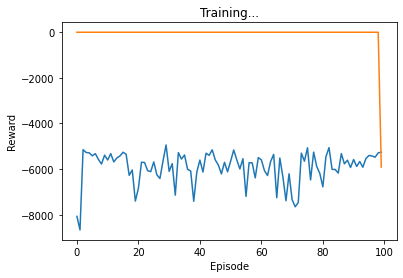

5
reward -4.553443528828067
current_state2 [0.0, 0.0, 2.5534435288280672, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -6.128436187870073
current_state2 [0.0, 0.0, 4.128436187870073, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -7.360007619733439
current_state2 [0.0, 0.0, 5.360007619733439, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -9.335554320628493
current_state2 [0.0, 0.0, 7.335554320628493, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -10.787636860776981
current_state2 [1.4266304347826089, 0.0, 7.361006425994372, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -11.882634844382142
current_state2 [2.8532608695652177, 0.0, 7.029373974816924, 0.0, 1, 0, 0, 1, 0, 0]
5
reward -19.342210875206888
current_state2 [4.279891304347826, 5.356676079486579, 7.7056434913724825, 0.0, 1, 0, 0, 1, 0, 0]
1
reward -21.915854524938823
current_state2 [6.402675905359066, 6.439473134016308, 7.073705485563449, 0.0, 1, 0, 0, 0, 1, 0]
1
reward -30.532252310990923
current_state2 [8.559782608695654, 12.878946268032616, 7.0935234342626545, 0.0, 0, 1, 0, 0, 1, 0]
5
reward -25.

In [ ]:
# async def run():
for episode in range(100):
    rewards = 0
    count = 0
    reset()
    traci.simulationStep()
    previous_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#     print(previous_phase)
    for seconds in range(100): 
#         traci.simulationStep()
#             if seconds >= 300: ??
#         if seconds%time_step == 0:
#             if done(count) >= 50:
#                 print('done')
#                 break
        if current_state1 is None:
            current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#             print('current_phase', current_phase)
            current_state1 = get_state()
#             print('current_state1', current_state1)
            junct = get_action_junction(current_state1)
            current_state2 = copy.deepcopy(current_state1)
#             print('current_state2', current_state2)
            current_state2.append(int(junct))
#             print('current_state2', current_state2)
        else:
            current_state1 = next_state1
            current_state2 = next_state2
        action = get_action_phase(current_state2)
#         print('junction', junct)
#         print('action', action)
        reward, next_state1, next_state2 = take_action(action, junct) 
        if previous_state1 is not None:
            memory1.push(torch.tensor([current_state1]), torch.tensor([[junct]]), torch.tensor([next_state1]), torch.tensor([reward]))
            memory2.push(torch.tensor([current_state2]), torch.tensor([[action]]), torch.tensor([next_state2]), torch.tensor([reward]))
        optimize_model1()
        optimize_model2()
        previous_state1 = current_state1
        previous_state2 = current_state2
        rewards += reward
    reward_memory.append(rewards)
    plot_durations()

    if episode % TARGET_UPDATE == 0:
        target_net1.load_state_dict(policy_net1.state_dict())
        target_net2.load_state_dict(policy_net2.state_dict())
    traci.close()

print('Complete')
plt.ioff()
plt.show()

In [ ]:
# async def run():
for episode in range(101,500):
    rewards = 0
    count = 0
    reset()
    traci.simulationStep()
    previous_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#     print(previous_phase)
    for seconds in range(100): 
#         traci.simulationStep()
#             if seconds >= 300: ??
#         if seconds%time_step == 0:
#             if done(count) >= 50:
#                 print('done')
#                 break
        if current_state1 is None:
            current_phase = [traci.trafficlight.getPhase(id[key]) for key in ['virtual','KasemRat']]
#             print('current_phase', current_phase)
            current_state1 = get_state()
#             print('current_state1', current_state1)
            junct = get_action_junction(current_state1)
            current_state2 = copy.deepcopy(current_state1)
#             print('current_state2', current_state2)
            current_state2.append(int(junct))
#             print('current_state2', current_state2)
        else:
            current_state1 = next_state1
            current_state2 = next_state2
        action = get_action_phase(current_state2)
#         print('junction', junct)
#         print('action', action)
        reward, next_state1, next_state2 = take_action(action, junct) 
        if previous_state1 is not None:
            memory1.push(torch.tensor([current_state1]), torch.tensor([[junct]]), torch.tensor([next_state1]), torch.tensor([reward]))
            memory2.push(torch.tensor([current_state2]), torch.tensor([[action]]), torch.tensor([next_state2]), torch.tensor([reward]))
        optimize_model1()
        optimize_model2()
        previous_state1 = current_state1
        previous_state2 = current_state2
        rewards += reward
    reward_memory.append(rewards)
    plot_durations()

    if episode % TARGET_UPDATE == 0:
        target_net1.load_state_dict(policy_net1.state_dict())
        target_net2.load_state_dict(policy_net2.state_dict())
    traci.close()

print('Complete')
plt.ioff()
plt.show()